In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import f_oneway
import os
import re
import csv
from matplotlib.patches import Ellipse
import seaborn as sns
import matplotlib.pylab as pl
from tqdm import tqdm

In [2]:
root_folder = '/Users/andreizn/Desktop/Skoltech_PhD/Projects/eSports_project/1_eSports_ERP/4_ET_EEG_data/3_Combined data/'
data_folders = np.sort(np.array(os.listdir(root_folder)))
data_folders = data_folders[[data_folders[i]!='.DS_Store' for i in range(len(data_folders))]]

In [3]:
data_folders

array(['sub3001_20210524', 'sub3002_20210524', 'sub3004_20210525',
       'sub3005_20210525', 'sub3006_20210526', 'sub5002_20210302',
       'sub5003_20210305', 'sub5006_20210318', 'sub5007_20210323',
       'sub5008_20210331'], dtype='<U16')

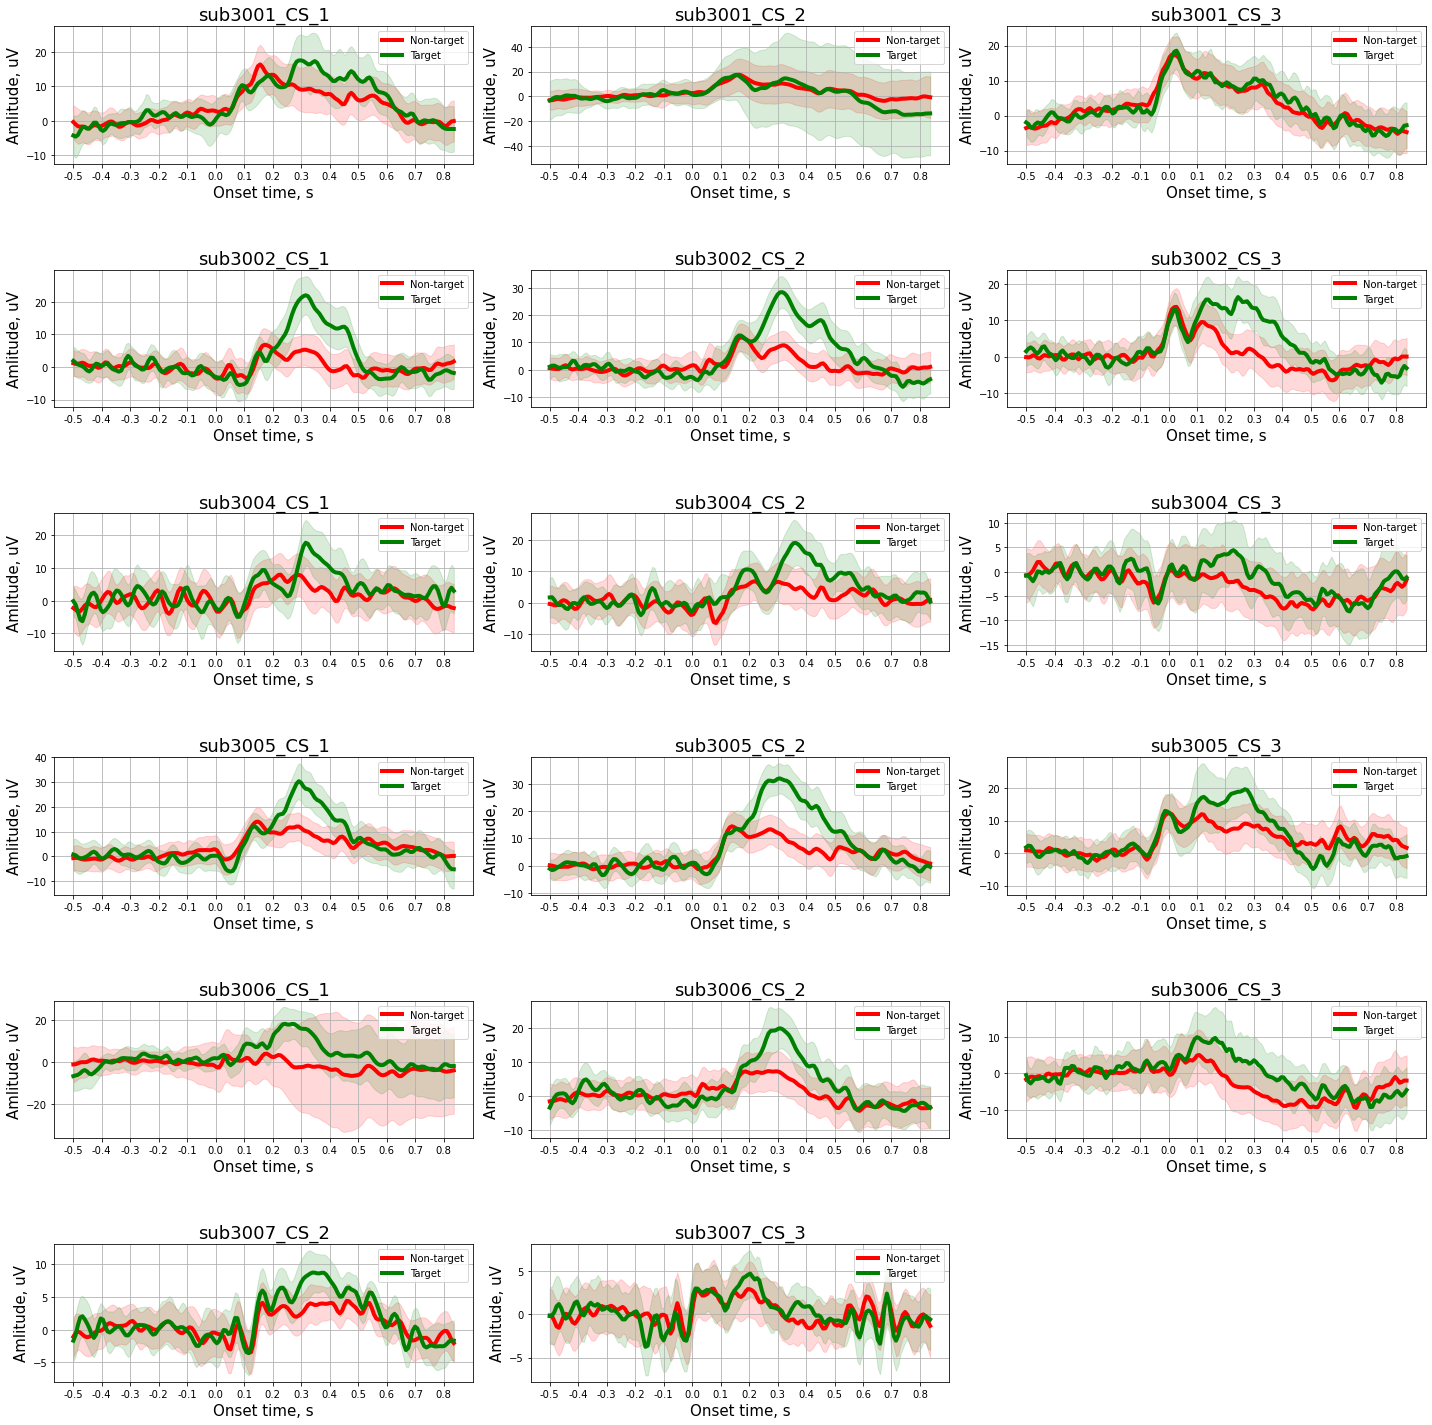

In [4]:
fig = plt.figure(figsize=(20,60))
nfiles = len(data_folders) * 3
# plt.subplots(nrows=nfiles, ncols=3)               

for fld_idx in range(0, len(data_folders)):
    cur_folder = root_folder + '/' + data_folders[fld_idx]
    if data_folders[fld_idx][3] == '5':
        break
    files = np.sort(os.listdir(cur_folder))
    
    for file_idx in range(0,len(files)):
        
        filename_data = cur_folder + '/' + files[file_idx]
#         filename_trigger = cur_folder + '/' + files[file_idx+2]
        
        mat_contents_data = sio.loadmat(filename_data)
        all_data = np.array(mat_contents_data['combined_data'])
        data = all_data[0:32, :, :]
        trig = all_data[32, :, :]
#         trig = trig.reshape(1, trig.shape[0], trig.shape[1])
        et_data = all_data[33:, :, :]

#         data = np.array(mat_contents_data['EEG_data'])
#         data = np.moveaxis(data, 1, 2)
#         trig = np.array(mat_contents_trigger['EEG_trigger'])
        
        non_target_idx = trig == 1
        non_target_idx = non_target_idx[:,0]
        target_idx = trig == 2
        target_idx = target_idx[:,0]

        # start, end = int((0.3 + 0.5) * 120), int((0.4 + 0.5) * 120)
        start, end = int((-0.5 + 0.5) * 250), int((0.9 + 0.5) * 250)
        ts_idx = slice(start, end)

        chs = [24,]
        # chs = np.arange(0,32)

        for ch_idx in chs:
            
#                 print(1 + fld_idx*3 + file_idx // 2)
            ax = plt.subplot(nfiles, 3, 1 + fld_idx*3 + file_idx)
            fig.tight_layout(h_pad=5.0)

            # plot mean and confidence interval for non-target data
            nt_data = data[ch_idx, non_target_idx, ts_idx]
            ax.plot(np.mean(nt_data, axis=0), label='Non-target', linewidth=4, c='r')
            ci_non_target = 0.5*np.std(nt_data, axis=0)
            ax.fill_between(np.arange(np.shape(nt_data)[1]), (np.mean(nt_data, axis=0) - ci_non_target), (np.mean(nt_data, axis=0)+ci_non_target), color='r', alpha=.15)

            # plot mean and confidence interval for target data
            t_data = data[ch_idx, target_idx, ts_idx]
            ax.plot(np.mean(t_data, axis=0), label='Target', linewidth=4, c='g')
            ci_target = 0.5*np.std(t_data, axis=0)
            ax.fill_between(np.arange(np.shape(nt_data)[1]), (np.mean(t_data, axis=0) - ci_target), (np.mean(t_data, axis=0)+ci_target), color='g', alpha=.15)
            
            
            
            # plot trial average for non-target data
            n_trials = np.shape(nt_data)[0]
            n_tp = np.shape(nt_data)[1]
            trial_average_nt = np.ones((n_trials, n_tp))
            tr_av_val_nt = np.mean(nt_data, axis=1)

            for trial_idx in range(n_trials):
                trial_average_nt[trial_idx, :] *= tr_av_val_nt[trial_idx]
        #     plt.plot(trial_average_nt.T, linewidth=0.5, c='b', alpha=0.7)

            # plot trial average for target data
            n_trials = np.shape(t_data)[0]
            n_tp = np.shape(t_data)[1]
            trial_average_t = np.ones((n_trials, n_tp))
            tr_av_val_t = np.mean(t_data, axis=1)
            
            for trial_idx in range(n_trials):
                trial_average_t[trial_idx, :] *= tr_av_val_t[trial_idx]

        #     plt.plot(trial_average_t.T, linewidth=0.5, c='r', alpha=0.7)

            plt.title(files[file_idx][0:7] + '_CS_' + files[file_idx][12:13], fontsize=18)

            plt.xticks(np.arange(0, np.shape(nt_data)[1], 12.5), np.round(1/250 * np.arange(start, end, 25) - 0.5, 2))
            plt.legend()
            plt.xlabel('Onset time, s', fontsize=15)
            plt.ylabel('Amlitude, uV', fontsize=15)
            plt.grid()


#                 plt.figure(figsize=(15,7))
#                 plt.hist(tr_av_val_nt, density=True, bins=20, label = 'non target')
#                 plt.hist(tr_av_val_t, density=True, bins=20, alpha=0.5, label = 'target')
#                 plt.legend()
#                 plt.grid()
#                 plt.show()

plt.show()
        

In [5]:
et_data.shape

(8, 224, 168)

### 0:31 - EEG channels
### 32 - trigger channel
### 33 (0) - Gaze point (distance to target)
### 34 (1) - Eye-movement type
### 35 (2) - Pupil diameter
### 36 (3) - Stimuli type
### 37 (4) - Gaze point X
### 38 (5) - Gaze point Y
### 39 (6) - Image name 
### 40 (7) - Gaze point (distance to the center of the screen)

https://www.sciencedirect.com/science/article/pii/S0042698903000841#SEC1

In [4]:
target_coord_file = '/Users/andreizn/Desktop/Skoltech_PhD/Projects/eSports_project/1_eSports_ERP/0_eSports_ERP_exp_and_analysis/Analysis/EEG_ET_analysis/labeling.csv'
target_coord = pd.read_csv(target_coord_file, header=None, names=['image', 'x', 'y'])
# target_coord_cur = target_coord[target_coord.image.values == int(et_data[6, 1, 0])]

In [5]:
# gpx, gpy = et_data[4, :], et_data[5, :]
# for trial_num in range(5):

#     fig = plt.figure(figsize = (19, 11))
#     plt.plot([1920/2 - 450/2, 1920/2 + 450/2], [1080/2-450/2, 1080/2-450/2], c='g')
#     plt.plot([1920/2 - 450/2, 1920/2 + 450/2], [1080/2+450/2, 1080/2+450/2], c='g')
#     plt.plot([1920/2 - 450/2, 1920/2 - 450/2], [1080/2-450/2, 1080/2+450/2], c='g')
#     plt.plot([1920/2 + 450/2, 1920/2 + 450/2], [1080/2-450/2, 1080/2+450/2], c='g')
#     plt.xlim([0, 1920])
#     plt.ylim([0, 1080])
#     plt.grid()

#     target_coord_cur = target_coord[target_coord.image.values == int(et_data[6, trial_num, 0])]
#     target_coord_x, target_coord_y = [], []
#     if len(target_coord_cur) > 0:
#         target_coord_x, target_coord_y = target_coord_cur.x.values[0], target_coord_cur.y.values[0]

#     for idx in range(len(gpx[trial_num, :])):
#         if target_coord_x:
#             plt.scatter(target_coord_x, target_coord_y, c='r', s=1000, marker=(5, 1))
#         plt.scatter(gpx[trial_num, idx], gpy[trial_num, idx], c='b', s=10)

#     plt.show()

In [5]:
def calculate_velocity(CFG, gpx, gpy):
    dt = 1/CFG['et_sr']
    v_x, v_y = np.zeros((len(gpx), )), np.zeros((len(gpy), ))
    v_x[0], v_x[1], v_x[-1], v_x[-2] = 0, 0, 0, 0
    v_y[0], v_y[1], v_y[-1], v_y[-2] = 0, 0, 0, 0
    for i in range(2, len(gpx)-2):
        v_x[i] = (gpx[i+2] + gpx[i+1] - gpx[i-1] - gpx[i-2]) / (6*dt)
        v_y[i] = (gpy[i+2] + gpy[i+1] - gpy[i-1] - gpy[i-2]) / (6*dt)
    v_x[1] = (v_x[1] + v_x[2]) / 2
    v_x[0] = (v_x[0] + v_x[1]) / 2
    v_x[-2] = (v_x[-2] + v_x[-3]) / 2
    v_x[-1] = (v_x[-1] + v_x[-2]) / 2

    v_y[1] = (v_y[1] + v_y[2]) / 2
    v_y[0] = (v_y[0] + v_y[1]) / 2
    v_y[-2] = (v_y[-2] + v_y[-3]) / 2
    v_y[-1] = (v_y[-1] + v_y[-2]) / 2
    
    return v_x, v_y

def visualize_et_data(CFG, DATA, file_idx, trial_num):
    
    # get config parameters from CFG
    screen_size = CFG['screen_size']
    img_size = CFG['img_size']
    lambda_par = CFG['lambda_par']
    
    # get trial data from DATA
    target_coord = DATA['target_coord']
    et_data_trial = DATA['et_data_trial']
    gpx = DATA['gpx_trial']
    gpy = DATA['gpy_trial']
    v_x = DATA['v_x_trial']
    v_y = DATA['v_y_trial']
    sigma_x = DATA['sigma_x_trial']
    sigma_y = DATA['sigma_y_trial']
    sac_idx = DATA['sac_idx']
    
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 1]}, figsize=(19,10))
    ax = axs[0]
    ax.plot([screen_size[0]/2 - img_size[0]/2, screen_size[0]/2 + img_size[0]/2], [screen_size[1]/2-img_size[1]/2, screen_size[1]/2-img_size[1]/2], c='g')
    ax.plot([screen_size[0]/2 - img_size[0]/2, screen_size[0]/2 + img_size[0]/2], [screen_size[1]/2+img_size[1]/2, screen_size[1]/2+img_size[1]/2], c='g')
    ax.plot([screen_size[0]/2 - img_size[0]/2, screen_size[0]/2 - img_size[0]/2], [screen_size[1]/2-img_size[1]/2, screen_size[1]/2+img_size[1]/2], c='g')
    ax.plot([screen_size[0]/2 + img_size[0]/2, screen_size[0]/2 + img_size[0]/2], [screen_size[1]/2-img_size[1]/2, screen_size[1]/2+img_size[1]/2], c='g')

    # for CS_3 experiment
    if file_idx == 2:
        target_coord_cur = target_coord[target_coord.image.values == int(et_data_trial[6, 0])]
        target_coord_x, target_coord_y = [], []
        if len(target_coord_cur) > 0:
            target_coord_x, target_coord_y = target_coord_cur.x.values[0], target_coord_cur.y.values[0]
        if target_coord_x:
            ax.scatter(target_coord_x, target_coord_y, c='r', s=1000, marker=(5, 1))

    for idx in range(len(gpx)):
        if idx not in sac_idx:
            ax.scatter(gpx[idx], gpy[idx], c='b', s=8)

    if sac_idx:
        for sac_idx_cur in sac_idx:
            if abs(v_x[sac_idx_cur-1]) > lambda_par*sigma_x and abs(v_y[sac_idx_cur-1]) > lambda_par*sigma_y:
                ax.plot(gpx[sac_idx_cur-1:sac_idx_cur+1], gpy[sac_idx_cur-1:sac_idx_cur+1], linewidth=5, c='r')
            else:
                ax.scatter(gpx[sac_idx_cur], gpy[sac_idx_cur], c='r')


    ax.set_xlim([0, screen_size[0]])
    ax.set_ylim([0, screen_size[1]])
    
    colors = pl.cm.jet(np.linspace(0,1,100))
    
    for idx in range(1, len(gpx)):
        v_max = max(np.sqrt(v_x**2 + v_y**2))
        v = np.sqrt(v_x[idx]**2 + v_y[idx]**2)

        linewidth = 1 + 4*v/v_max; 
#                 col_frac = int(np.round(99*v/v_max))
#                 ax.plot(gpx[idx-1:idx+1], gpy[idx-1:idx+1], c=colors[col_frac], linewidth=linewidth, alpha=0.09+0.9*v/v_max)
        col_frac = int(np.round(99*idx/len(gpx)))
        ax.plot(gpx[idx-1:idx+1], gpy[idx-1:idx+1], c=colors[col_frac], linewidth=linewidth, alpha=0.09+0.9*v/v_max)

    ax = axs[1]
    new_cmap = plt.get_cmap('jet')
    arr = np.linspace(0, 50, 100).reshape((100, 1))
    ax.imshow(arr, aspect='auto', cmap = new_cmap)
    ax.set_xlim([0,0.5])
    ax.set_ylim([0,99])
    plt.xticks([])
    plt.yticks(np.arange(0,91,10), np.arange(0, v_max, int(v_max/9)))
    
    plt.show()
    
def visualize_et_velocities(CFG, DATA, file_idx, trial_num):

    # get config parameters from CFG
    screen_size = CFG['screen_size']
    img_size = CFG['img_size']
    lambda_par = CFG['lambda_par']
    
    # get trial data from DATA
    target_coord = DATA['target_coord']
    et_data_trial = DATA['et_data_trial']
    gpx = DATA['gpx_trial']
    gpy = DATA['gpy_trial']
    v_x = DATA['v_x_trial']
    v_y = DATA['v_y_trial']
    sigma_x = DATA['sigma_x_trial']
    sigma_y = DATA['sigma_y_trial']
    sac_idx = DATA['sac_idx']
    
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 1]}, figsize=(15,10))
    ax = axs[0]
    ell = Ellipse(xy=[0,0], width=2*CFG['lambda_par']*sigma_x, height=2*CFG['lambda_par']*sigma_y, angle=0)
    ax.add_artist(ell)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.3)
    ell.set_facecolor([0.2,0.2,0.5])

    colors = pl.cm.jet(np.linspace(0,1,100))

    for idx in range(1, len(gpx)):
        v_max = max(np.sqrt(v_x**2 + v_y**2))
        v = np.sqrt(v_x[idx]**2 + v_y[idx]**2)
        col_frac = int(np.round(99*v/v_max))
        linewidth = 1 + 4*v/v_max; 

        ax.plot(v_x[idx-1:idx+1], v_y[idx-1:idx+1], c=colors[col_frac], linewidth=linewidth, alpha=0.09+0.9*v/v_max)

    ax.scatter(v_x, v_y)

    if sac_idx:
        for sac_idx_cur in sac_idx:
            if abs(v_x[sac_idx_cur-1]) > CFG['lambda_par']*sigma_x and abs(v_y[sac_idx_cur-1]) > CFG['lambda_par']*sigma_y:
                ax.plot(v_x[sac_idx_cur-1:sac_idx_cur+1], v_y[sac_idx_cur-1:sac_idx_cur+1], linewidth=5, c='r')
            else:
                ax.scatter(v_x[sac_idx_cur], v_y[sac_idx_cur], c='r')

    v_lim = max(max(abs(v_x)), max(abs(v_y)))
    ax.set_xlim([-1.1*v_lim, 1.1*v_lim])
    ax.set_ylim([-1.1*v_lim, 1.1*v_lim])

    ax = axs[1]
    new_cmap = plt.get_cmap('jet')
    arr = np.linspace(0, 50, 100).reshape((100, 1))
    ax.imshow(arr, aspect='auto', cmap = new_cmap)
    ax.set_xlim([0,0.5])
    ax.set_ylim([0,99])
    plt.xticks([])
    plt.yticks(np.arange(0,91,10), np.arange(0, v_max, int(v_max/9)))

    plt.show()

In [6]:
data_folders

array(['sub3001_20210524', 'sub3002_20210524', 'sub3004_20210525',
       'sub3005_20210525', 'sub3006_20210526', 'sub5002_20210302',
       'sub5003_20210305', 'sub5006_20210318', 'sub5007_20210323',
       'sub5008_20210331'], dtype='<U16')

In [31]:
CFG = dict()
DATA = dict()

et_sr = 125 # Hz
lambda_par = 4
screen_size = (1920, 1080)
img_size = (450, 450)

# save parameters to the config dictionary CFG
CFG['et_sr'] = et_sr # Hz
CFG['lambda_par'] = lambda_par
CFG['screen_size'] = screen_size
CFG['img_size'] = img_size

num_folders = len(data_folders)
x = np.arange(screen_size[0]/2 - img_size[0]/2, screen_size[0]/2 + img_size[0]/2, 5)
y = np.arange(screen_size[1]/2 - img_size[1]/2, screen_size[1]/2 + img_size[1]/2, 5)
num_trials = 224
v_image = np.zeros((num_folders, num_trials, x.shape[0], y.shape[0]))
dist_th = img_size[0] / 15

# iterate over subject folders
for fld_idx in tqdm(range(num_folders)):
    cur_folder = root_folder + '/' + data_folders[fld_idx]
    files = np.sort(os.listdir(cur_folder))
    
    
    # iterate over files of experiments
    for file_idx in range(2,3):#len(files)):
        filename_data = cur_folder + '/' + files[file_idx]       
        mat_contents_data = sio.loadmat(filename_data)
        all_data = np.array(mat_contents_data['combined_data'])
        et_data = all_data[33:, :, :]
        
        num_trials = et_data.shape[1]
 
        # iterate over trials
        for trial_num in range(num_trials):
            et_data_trial = et_data[:, trial_num, :]
            gpx, gpy = et_data_trial[4, :], et_data_trial[5, :]
            v_x, v_y = calculate_velocity(CFG, gpx, gpy)
            v = np.sqrt(v_x**2 + v_y**2)
            sigma_x, sigma_y = np.std(v_x), np.std(v_y)
            sac_idx_x = np.argwhere(abs(v_x) > lambda_par*sigma_x).ravel()
            sac_idx_y = np.argwhere(abs(v_y) > lambda_par*sigma_y).ravel()
            sac_idx = list(set(sac_idx_x).intersection(set(sac_idx_y)))
            
            DATA['target_coord'] = target_coord
            DATA['et_data_trial'] = et_data_trial
            DATA['gpx_trial'] = gpx
            DATA['gpy_trial'] = gpy
            DATA['v_x_trial'] = v_x
            DATA['v_y_trial'] = v_y
            DATA['sigma_x_trial'] = sigma_x
            DATA['sigma_y_trial'] = sigma_y
            DATA['sac_idx'] = sac_idx
            
            for x_idx in range(x.shape[0]):
                for y_idx in range(y.shape[0]):
                    closest_cells = []
                    for ts in range(len(gpx)):
                        x_cur, y_cur = x[x_idx], y[y_idx]
                        gpx_cur, gpy_cur = gpx[ts], gpy[ts]
                        v_cur = v[ts]
                        dist_cur = np.sqrt((x_cur - gpx_cur)**2 + (y_cur - gpy_cur)**2)
#                         v_image[fld_idx, trial_num, x_idx, y_idx] += 1 / (1 + dist_cur)**0.5 #v_cur / (1 + dist_cur)**0.5
                        if dist_cur < dist_th:
                            closest_cells.append(v_cur)
                    if not closest_cells:
                        v_image[fld_idx, trial_num, x_idx, y_idx] = 0
                    else:
                        v_image[fld_idx, trial_num, x_idx, y_idx] = np.mean(closest_cells)
                    
                        
#             # scatter plot for et data
#             visualize_et_data(CFG, DATA, file_idx, trial_num)
            
#             # plot colored velocity scatter plot 
#             visualize_et_velocities(CFG, DATA, file_idx, trial_num)
            
                

100%|██████████| 10/10 [11:45<00:00, 70.51s/it]


In [32]:
np.shape(np.mean(v_image[0,:,:,:], axis=0))

(23, 23)

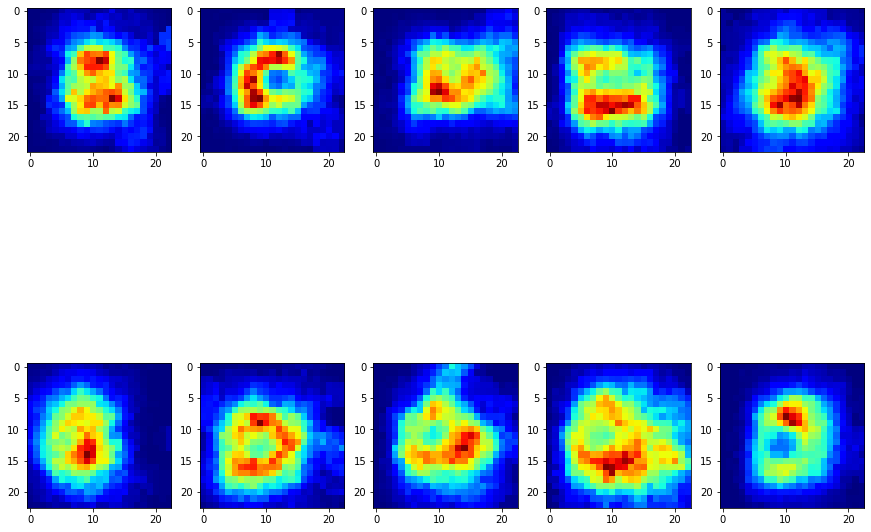

In [33]:
plt.figure(figsize=(15,12))
for sub_idx in range(num_folders):
    plt.subplot(2, 5, 1 + sub_idx)
    plt.imshow(np.mean(v_image[sub_idx,:,:,:], axis=0), cmap = plt.get_cmap('jet'))

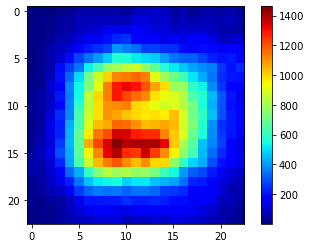

In [39]:
plt.imshow(np.mean(np.mean(v_image[0:5,:,:,:], axis=0), axis=0), cmap = plt.get_cmap('jet'))
plt.colorbar()

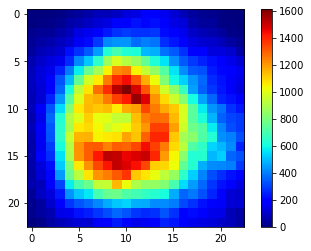

In [40]:
plt.imshow(np.mean(np.mean(v_image[5:,:,:,:], axis=0), axis=0), cmap = plt.get_cmap('jet'))
plt.colorbar()

In [45]:
a = np.mean(np.mean(v_image[0:5,:,:,:], axis=0), axis=0) - np.mean(np.mean(v_image[5:,:,:,:], axis=0), axis=0)

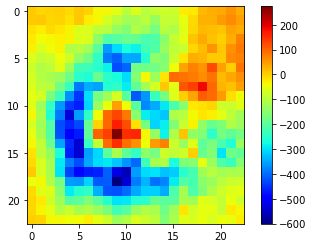

In [47]:
plt.imshow(a, cmap = plt.get_cmap('jet'))
plt.colorbar()

In [196]:
fld_idx

5

In [143]:
target_coord_cur

Empty DataFrame
Columns: [image, x, y]
Index: []

In [103]:
v_max

28047.88811618047

In [78]:
pattern = '^eye_sub[0-9][0-9][0-9][0-9]_CS_[0-9]*'

In [79]:
fl = [re.match(pattern, files[i]) is not None for i in range(len(files))]
files_ET = files[fl]

In [80]:
files_ET

array(['eye_sub3011_CS_1 Data Export.tsv',
       'eye_sub3011_CS_2 Data Export.tsv',
       'eye_sub3011_CS_3 Data Export.tsv'], dtype='<U50')

In [83]:
pd.read_csv(root_folder_ET + ET_folders[10] + '/' + files_ET[0], sep='\t')

Recording timestamp  Computer timestamp       Sensor Participant name  \
0                        0         12994067179          NaN          sub3011   
1                   272273         12994339452  Eye Tracker          sub3011   
2                   280606         12994347785  Eye Tracker          sub3011   
3                   288939         12994356118  Eye Tracker          sub3011   
4                   297273         12994364452  Eye Tracker          sub3011   
...                    ...                 ...          ...              ...   
47207            386815619         13380882798  Eye Tracker          sub3011   
47208            386823953         13380891132  Eye Tracker          sub3011   
47209            386832285         13380899464  Eye Tracker          sub3011   
47210            386843363         13380910542          NaN          sub3011   
47211            386999237         13381066416          NaN          sub3011   

      Recording name  Eyetracker timestamp           Event   Event value  \
0            sub3011                   NaN  RecordingStart           NaN   
1            sub3011          4.173449e+09             NaN           NaN   
2            sub3011          4.173458e+09             NaN           NaN   
3            sub3011          4.173466e+09             NaN           NaN   
4            sub3011          4.173474e+09             NaN           NaN   
...              ...                   ...             ...           ...   
47207        sub3011          4.559994e+09             NaN           NaN   
47208        sub3011          4.560002e+09             NaN           NaN   
47209        sub3011          4.560010e+09             NaN           NaN   
47210        sub3011                   NaN         TextEnd  Instructions   
47211        sub3011                   NaN    RecordingEnd           NaN   

       Gaze point X  Gaze point Y  ...  Pupil diameter right  Validity left  \
0               NaN           NaN  ...                   NaN            NaN   
1               NaN           NaN  ...                   NaN        Invalid   
2               NaN           NaN  ...                   NaN        Invalid   
3               NaN           NaN  ...                   NaN        Invalid   
4               NaN           NaN  ...                   NaN        Invalid   
...             ...           ...  ...                   ...            ...   
47207         333.0        1014.0  ...                  5.52        Invalid   
47208         331.0        1009.0  ...                  5.48        Invalid   
47209         329.0        1017.0  ...                  5.49        Invalid   
47210           NaN           NaN  ...                   NaN            NaN   
47211           NaN           NaN  ...                   NaN            NaN   

       Validity right  Presented Stimulus name  Presented Media name  \
0                 NaN                      NaN                   NaN   
1             Invalid                      NaN                   NaN   
2             Invalid                      NaN                   NaN   
3             Invalid                      NaN                   NaN   
4             Invalid                      NaN                   NaN   
...               ...                      ...                   ...   
47207           Valid             Instructions      Instructions.png   
47208           Valid             Instructions      Instructions.png   
47209           Valid             Instructions      Instructions.png   
47210             NaN                      NaN                   NaN   
47211             NaN                      NaN                   NaN   

       Eye movement type  Gaze event duration  Eye movement type index  \
0                    NaN                  NaN                      NaN   
1           EyesNotFound                 83.0                      1.0   
2           EyesNotFound                 83.0                      1.0   
3           EyesNotFoun

In [5]:
data.shape

(32, 200, 347)

In [13]:
mat_contents = sio.loadmat('sub5003_CS_3_EEG_ET_combined.mat')

In [14]:
data = np.array(mat_contents['data'])

In [15]:
np.shape(data)

(40, 224, 168)

In [106]:
non_target_idx = data[35, :, 1] == 1
target_idx = data[35, :, 1] == 2

In [107]:
np.shape(data[:, non_target_idx, :])

(39, 160, 168)

In [117]:
nt_data.shape

(160, 168)

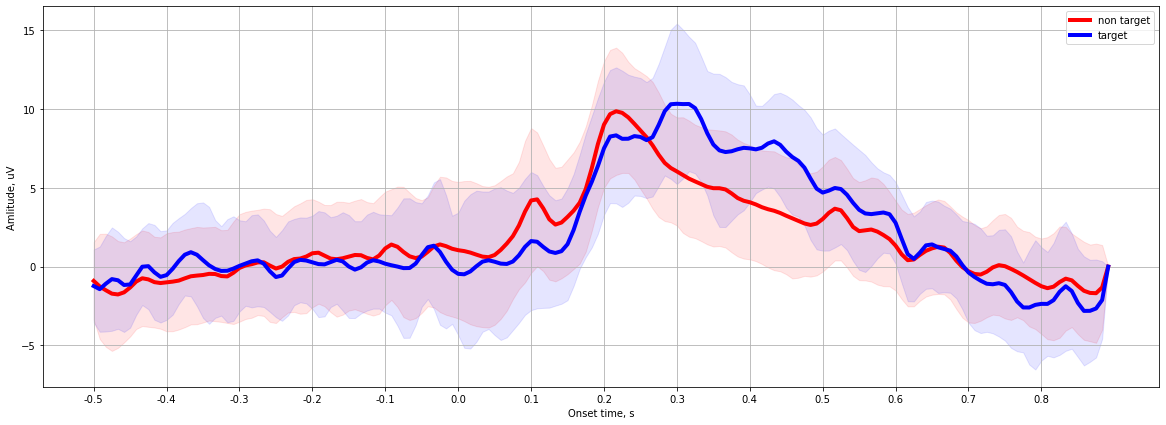

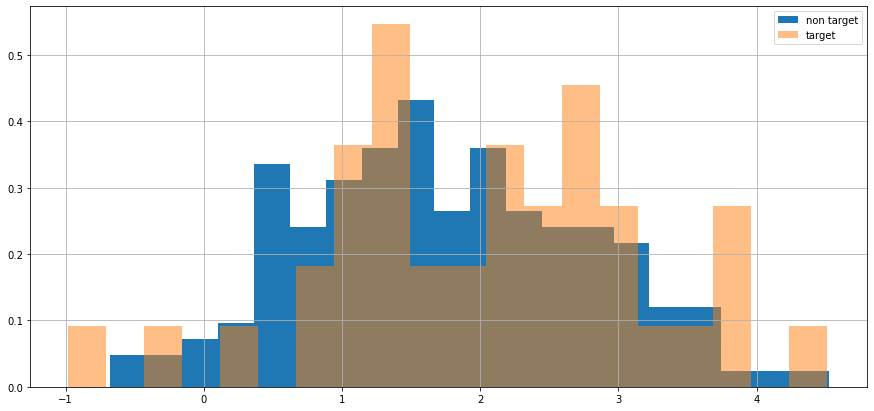

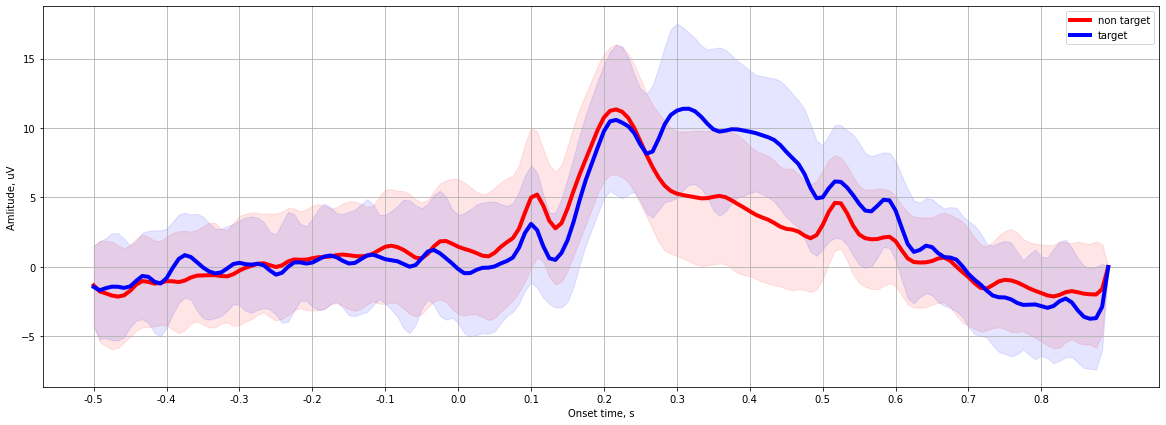

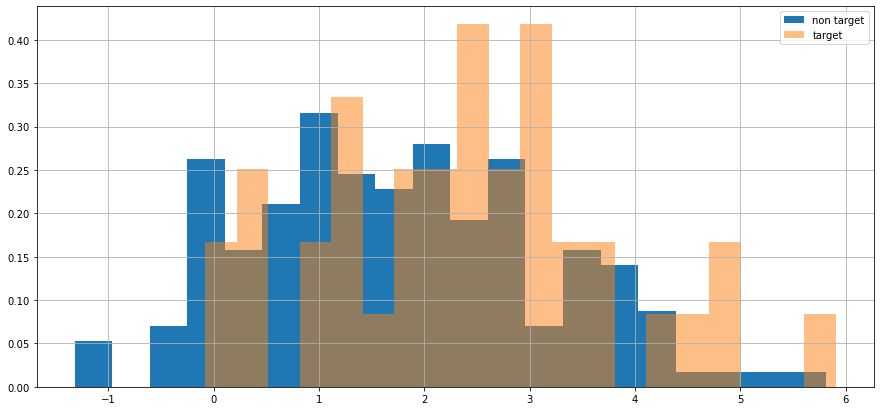

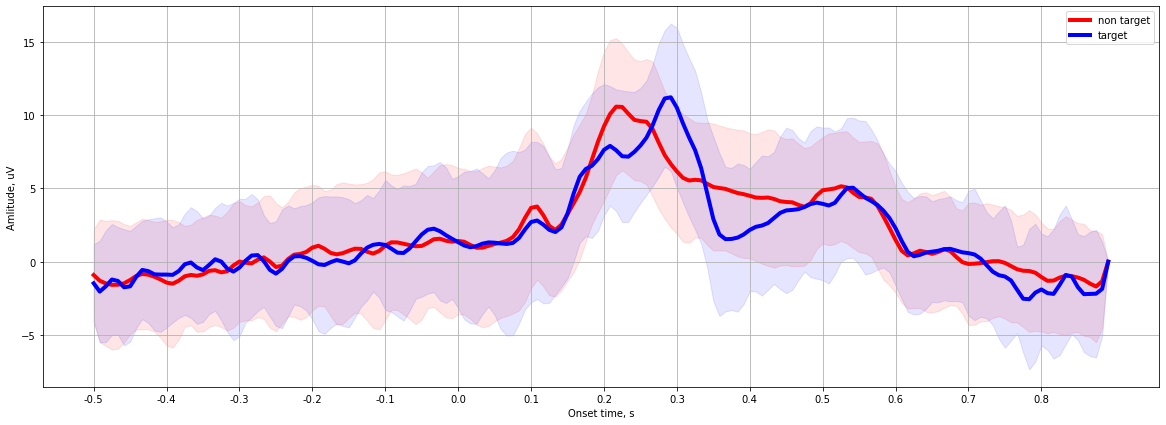

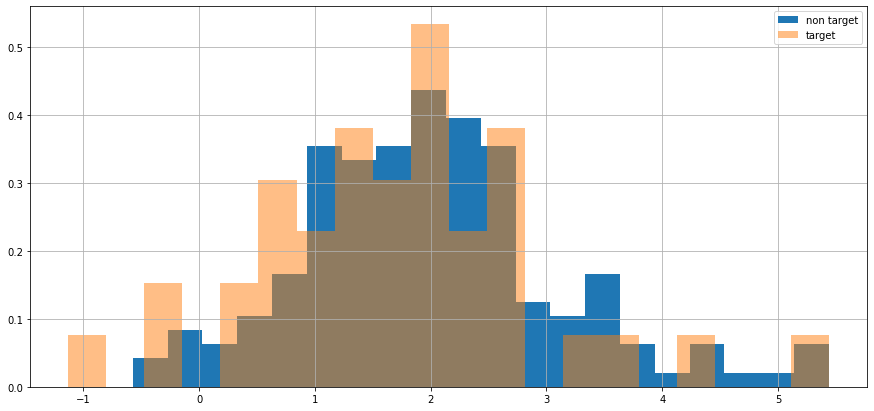

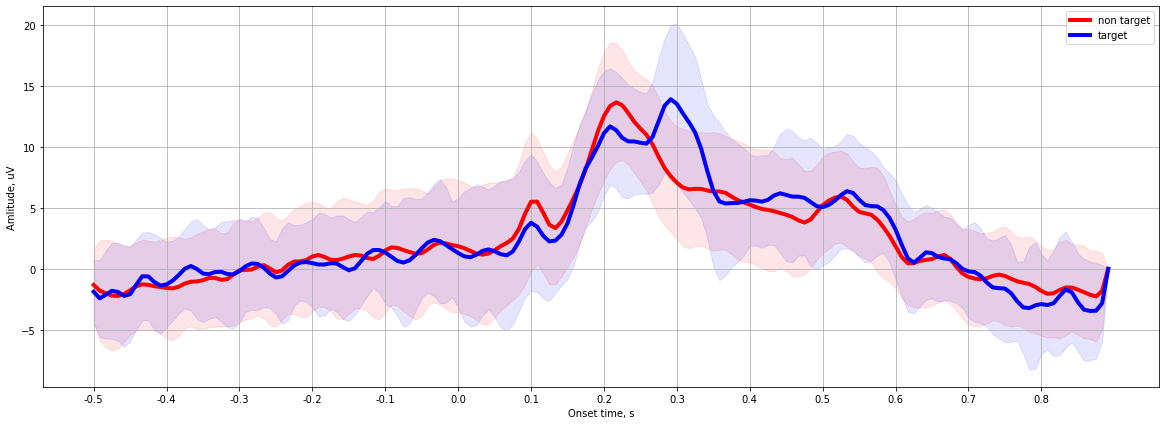

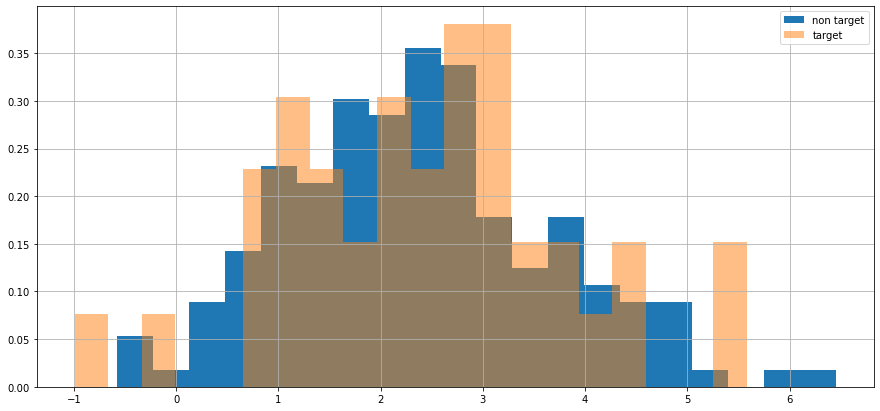

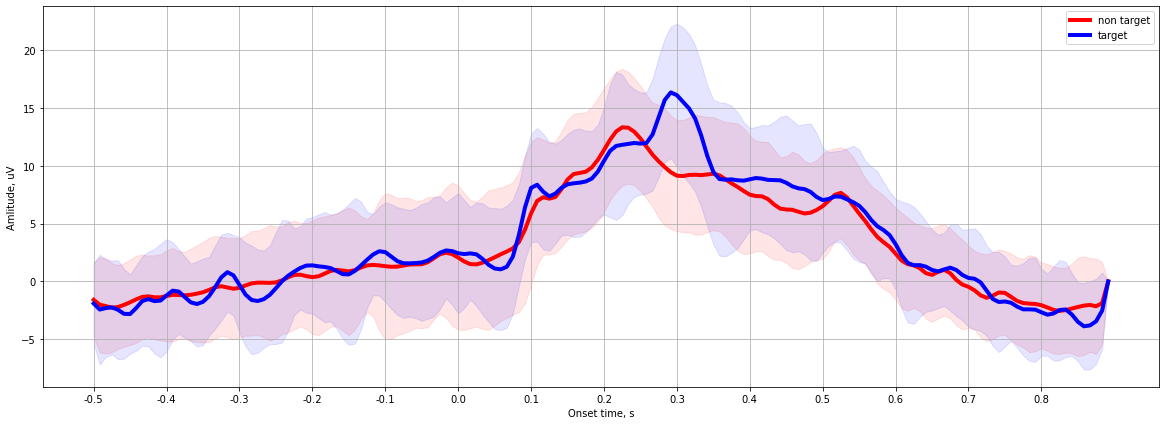

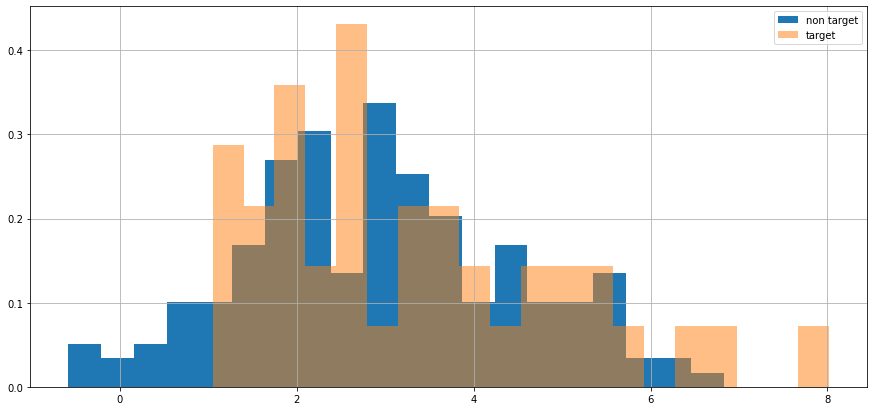

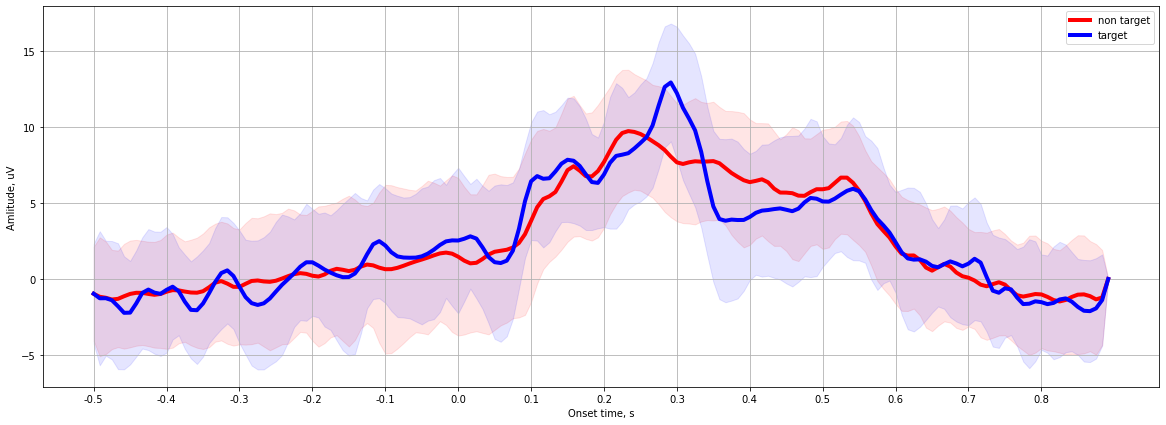

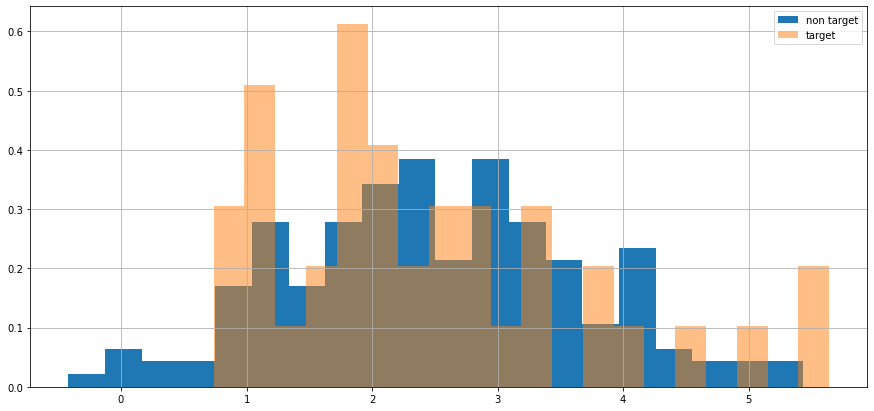

In [138]:
non_target_idx = data[35, :, 1] == 1
target_idx = data[35, :, 1] == 2

# start, end = int((0.3 + 0.5) * 120), int((0.4 + 0.5) * 120)
start, end = int((-0.5 + 0.5) * 120), int((0.9 + 0.5) * 120)
ts_idx = slice(start, end)

chs = [23, 24, 27, 28, 29, 30]
# chs = np.arange(0,32)

for ch_idx in chs:
    
    plt.figure(figsize=(20,7))
    
    # plot mean and confidence interval for non-target data
    nt_data = data[ch_idx, non_target_idx, ts_idx]
    plt.plot(np.mean(nt_data, axis=0), label='non target', linewidth=4, c='r')
    ci_non_target = np.std(nt_data, axis=0)
    plt.fill_between(np.arange(np.shape(nt_data)[1]), (np.mean(nt_data, axis=0) - ci_non_target), (np.mean(nt_data, axis=0)+ci_non_target), color='r', alpha=.1)

    # plot mean and confidence interval for target data
    t_data = data[ch_idx, target_idx, ts_idx]
    plt.plot(np.mean(t_data, axis=0), label='target', linewidth=4, c='b')
    ci_target = np.std(t_data, axis=0)
    plt.fill_between(np.arange(np.shape(nt_data)[1]), (np.mean(t_data, axis=0) - ci_target), (np.mean(t_data, axis=0)+ci_target), color='b', alpha=.1)
    
    # plot trial average for non-target data
    n_trials = np.shape(nt_data)[0]
    n_tp = np.shape(nt_data)[1]
    trial_average_nt = np.ones((n_trials, n_tp))
    tr_av_val_nt = np.mean(nt_data, axis=1)

    for trial_idx in range(n_trials):
        trial_average_nt[trial_idx, :] *= tr_av_val_nt[trial_idx]
#     plt.plot(trial_average_nt.T, linewidth=0.5, c='b', alpha=0.7)
    
    # plot trial average for target data
    n_trials = np.shape(t_data)[0]
    n_tp = np.shape(t_data)[1]
    trial_average_t = np.ones((n_trials, n_tp))
    tr_av_val_t = np.mean(t_data, axis=1)

    for trial_idx in range(n_trials):
        trial_average_t[trial_idx, :] *= tr_av_val_t[trial_idx]
        
#     plt.plot(trial_average_t.T, linewidth=0.5, c='r', alpha=0.7)

    plt.xticks(np.arange(0, np.shape(nt_data)[1], 12), np.round(1/120 * np.arange(start, end, 12) - 0.5, 2))
    plt.legend()
    plt.xlabel('Onset time, s')
    plt.ylabel('Amlitude, uV')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(15,7))
    plt.hist(tr_av_val_nt, density=True, bins=20, label = 'non target')
    plt.hist(tr_av_val_t, density=True, bins=20, alpha=0.5, label = 'target')
    plt.legend()
    plt.grid()
    plt.show()


In [78]:
from scipy import stats

In [110]:
stats.ttest_ind(t_PD, nt_PD, equal_var=True)

Ttest_indResult(statistic=7.204731244274576, pvalue=1.1912390347378346e-11)

In [111]:
stats.ttest_ind(t_PD, nt_PD, equal_var=False)

Ttest_indResult(statistic=7.022709624193127, pvalue=2.6376482611281606e-09)

In [97]:
np.mean(t_PD)

6.4850894939878545

In [98]:
np.mean(nt_PD)

6.016794456038632

In [99]:
f_oneway(t_PD, nt_PD)

F_onewayResult(statistic=0.5979016604642872, pvalue=0.44020230117272097)

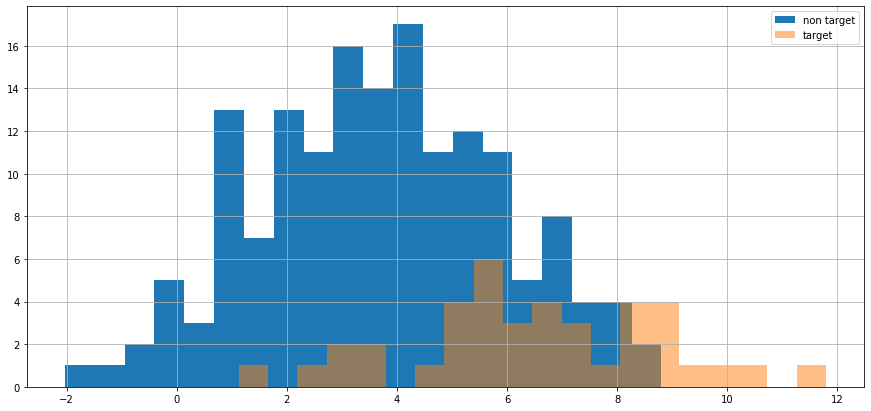

In [112]:
start, end = int((0.3 + 0.5) * 120), int((0.6 + 0.5) * 120)
# start, end = int((-0.5 + 0.5) * 120), int((0.9 + 0.5) * 120)
ts_idx = slice(start, end)

nt_PD = np.mean(data[23, non_target_idx, ts_idx], axis=1)
t_PD = np.mean(data[23, target_idx, ts_idx], axis=1)

plt.figure(figsize=(15,7))
plt.hist(nt_PD, density=False, bins=20, label = 'non target')
plt.hist(t_PD, density=False, bins=20, alpha=0.5, label = 'target')
plt.legend()
plt.grid()
plt.show()

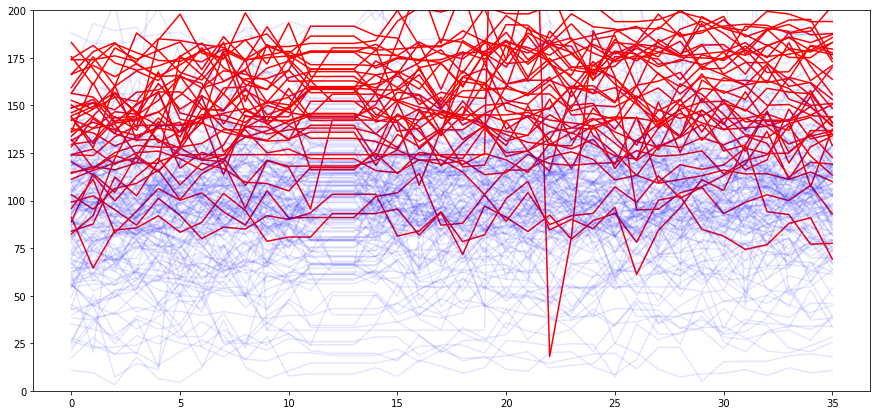

In [9]:
plt.figure(figsize=(15,7))
plt.plot(data[32, target_idx, ts_idx].T, c='r')
plt.plot(data[32, non_target_idx, ts_idx].T, c='b', alpha=0.1)
plt.ylim([0,200])
plt.show()

In [10]:
data[32, target_idx, :]

array([[ 47.67598976,  56.00892786,  26.47640459, ..., 142.04224724,
        145.96232391, 156.4161117 ],
       [ 36.79673899,  26.92582404,  29.06888371, ..., 135.2368293 ,
        126.19429464, 132.03408651],
       [ 86.83893136,  84.21995013,  78.23681998, ..., 135.00370365,
        143.08738589, 125.29964086],
       ...,
       [124.65151423, 116.21101497,  99.689518  , ..., 105.54619842,
        114.85643212, 102.3132445 ],
       [303.20455142, 134.11189358, 130.03461078, ..., 181.47176089,
        185.27007314, 183.91846019],
       [131.47243057, 140.13208055, 132.56319248, ..., 137.31715115,
        120.54044964, 135.36617007]])

In [11]:
np.shape(data[32, non_target_idx, :])

(160, 168)

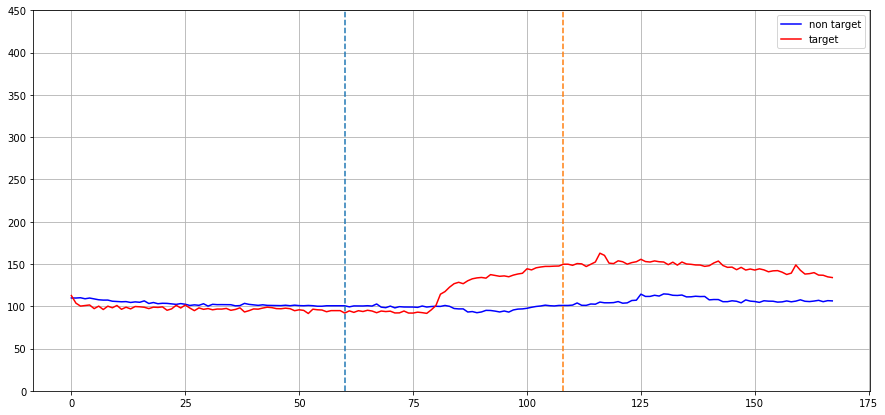

In [12]:
plt.figure(figsize=(15,7))
plt.plot(np.mean(data[32, non_target_idx, :], axis=0), c='b', label='non target')
plt.plot(np.mean(data[32, target_idx, :], axis=0), c='r', label='target')
plt.plot([(0.5)*120, (0.5)*120], [0, 450], '--')
plt.plot([(0.5+0.4)*120, (0.5+0.4)*120], [0, 450], '--')
plt.ylim([0,450])
plt.legend()
plt.grid()
plt.show()

In [13]:
len(target_idx)

200

In [14]:
grad_min = np.array([np.argmin(np.gradient(data[32, target_idx, :][i], edge_order=2)) for i in range(40)])

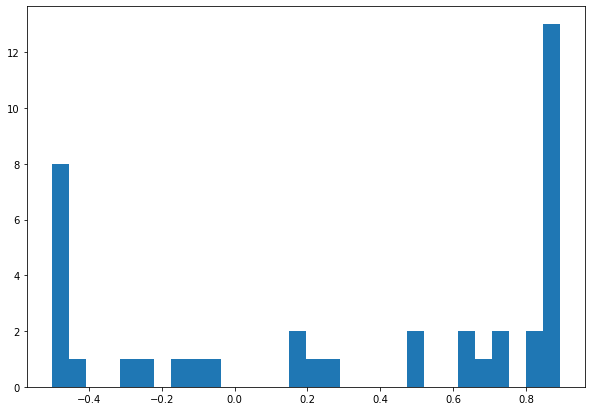

In [15]:
plt.figure(figsize=(10,7))
plt.hist(grad_min/120 - 0.5, bins=30)
plt.show()

In [16]:
sum(grad_min < 84)

16

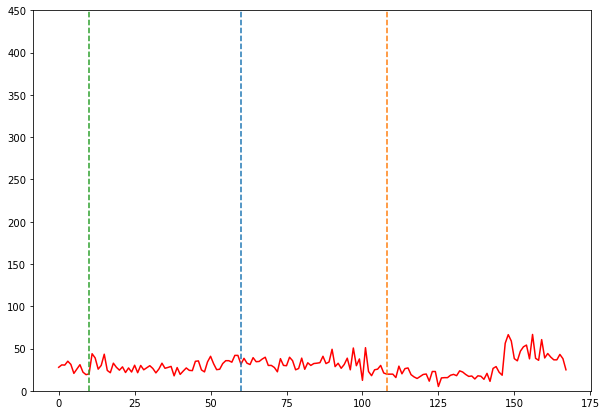

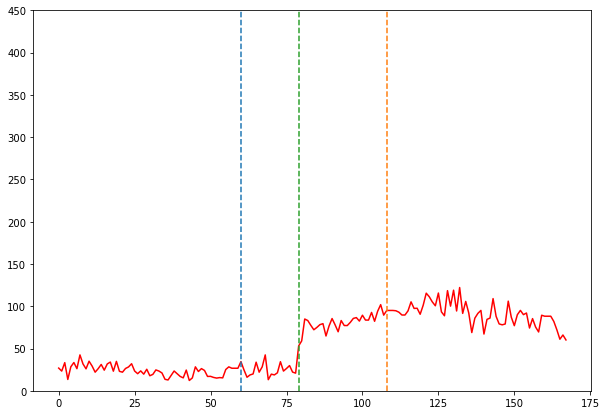

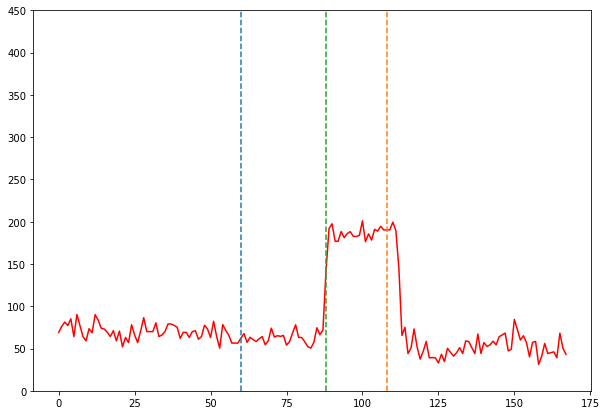

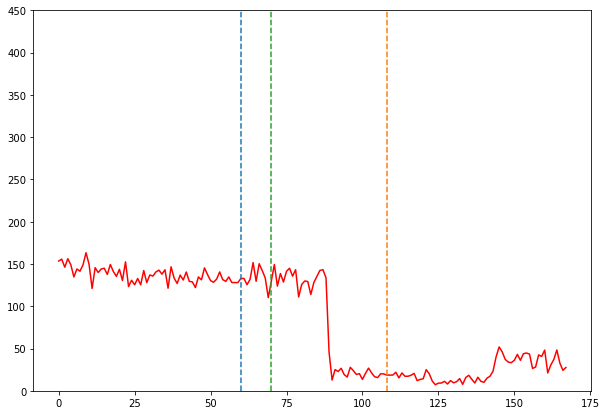

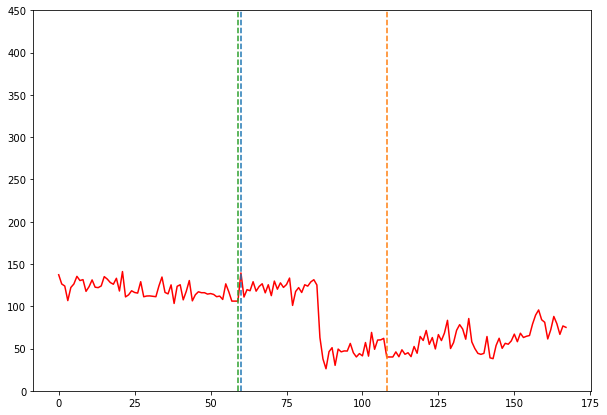

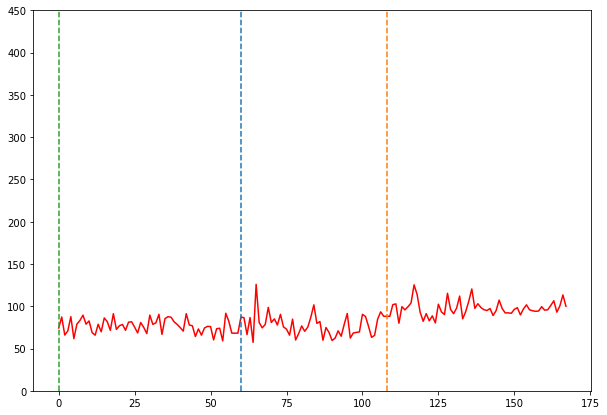

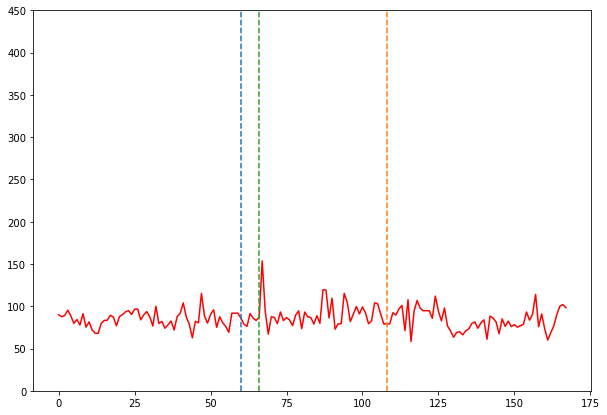

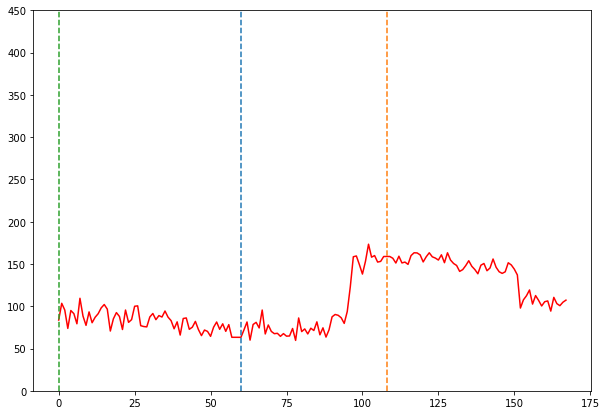

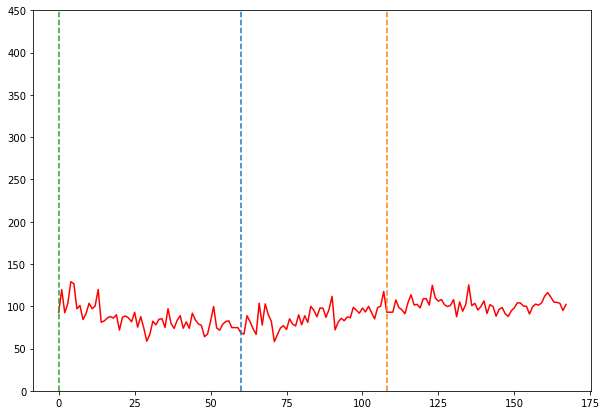

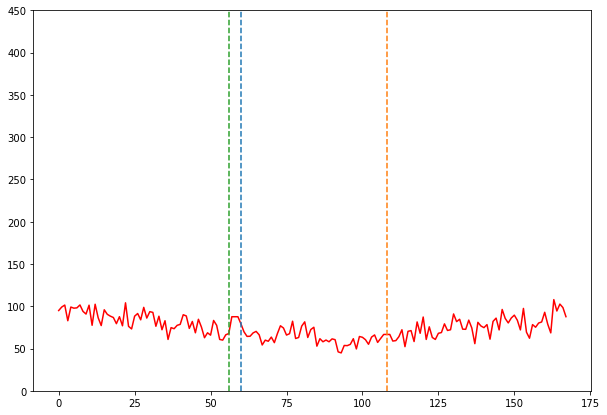

In [17]:
grad_max = np.array([np.argmax(np.gradient(data[32, non_target_idx, 0:108][i], edge_order=2)) for i in range(40)])
for i in range(10):
    plt.figure(figsize=(10,7))
    plt.plot(data[32, non_target_idx, :][i], c='r')
    plt.plot([(0.5)*120, (0.5)*120], [0, 450], '--')
    plt.plot([(0.5+0.4)*120, (0.5+0.4)*120], [0, 450], '--')
    plt.plot([grad_max[i], grad_max[i]], [0, 450], '--')
    plt.ylim([0,450])

<ipython-input-18-a09f834cc4db>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,7))


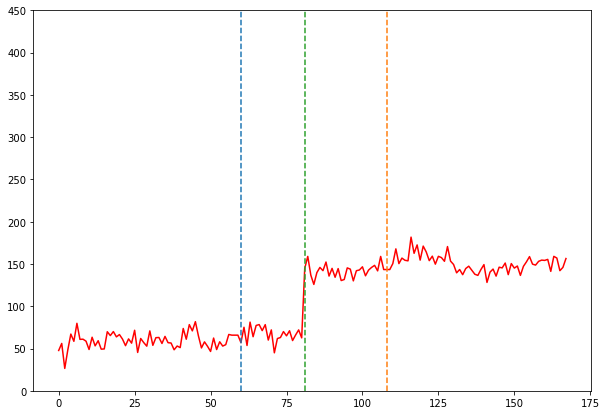

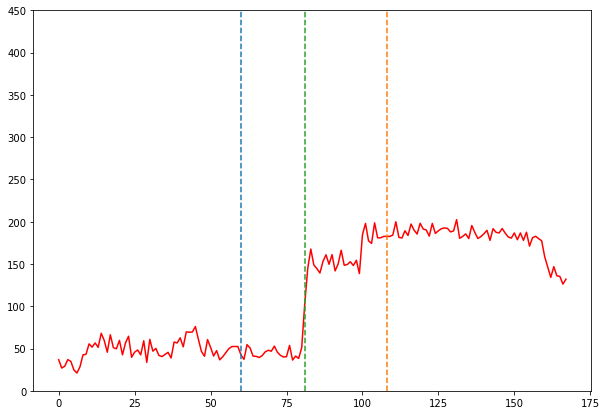

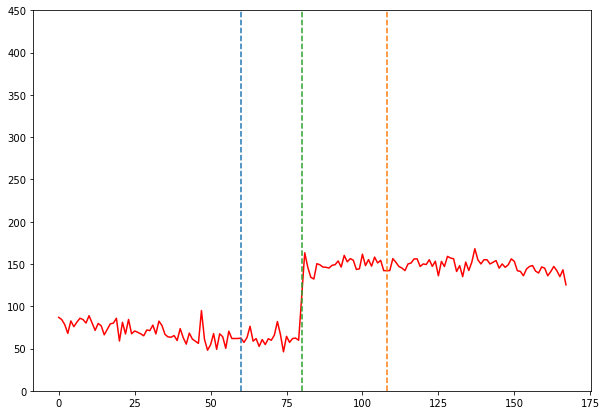

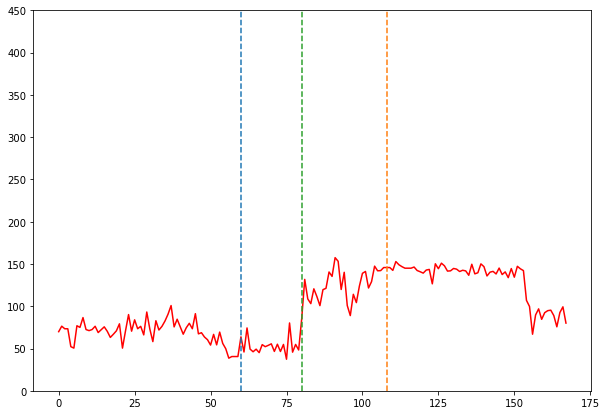

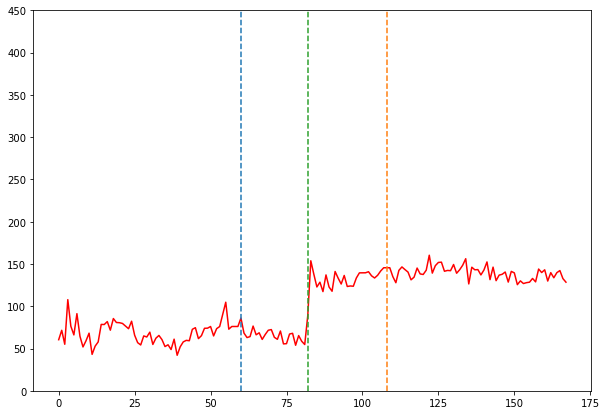

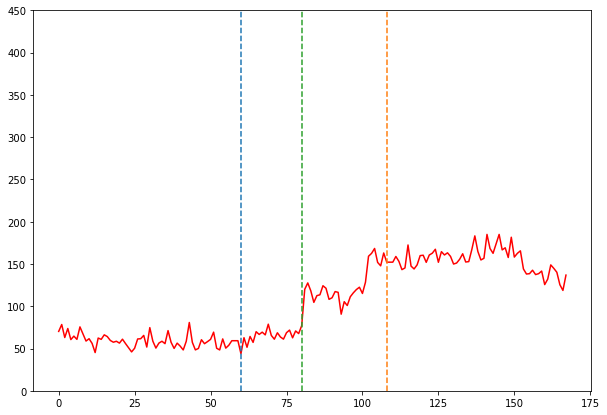

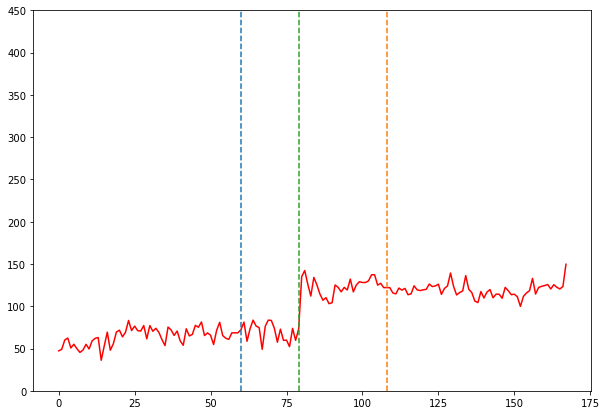

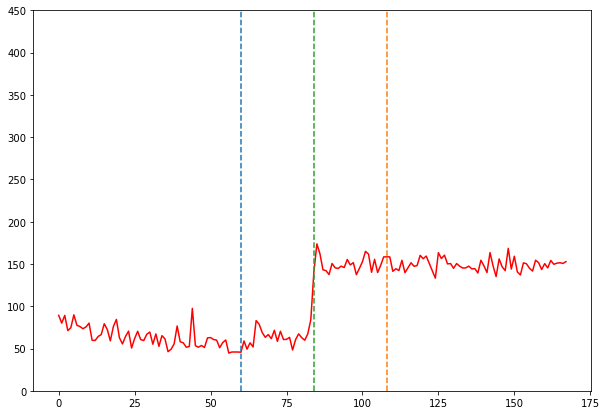

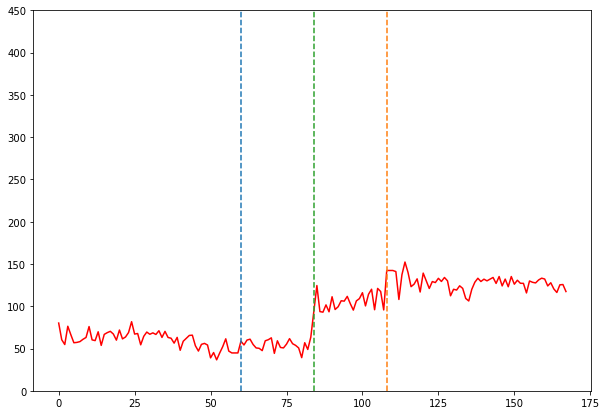

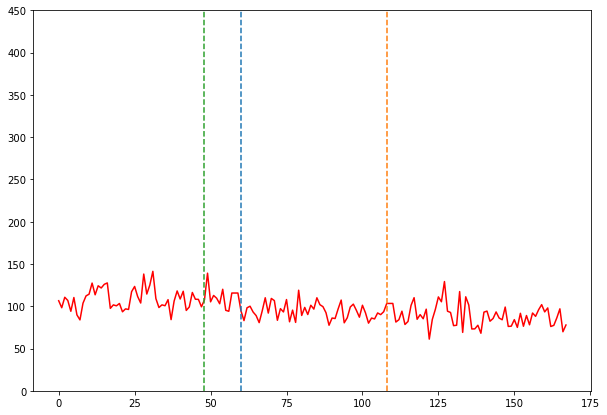

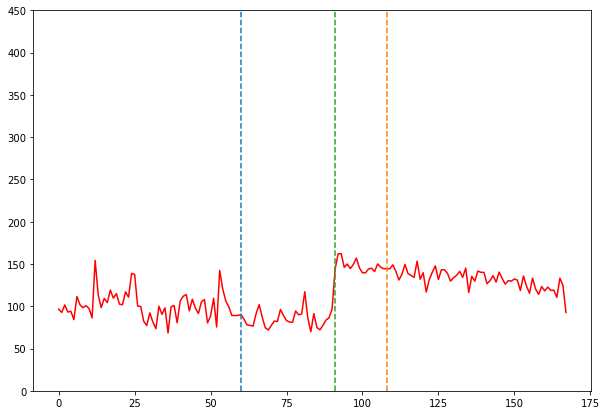

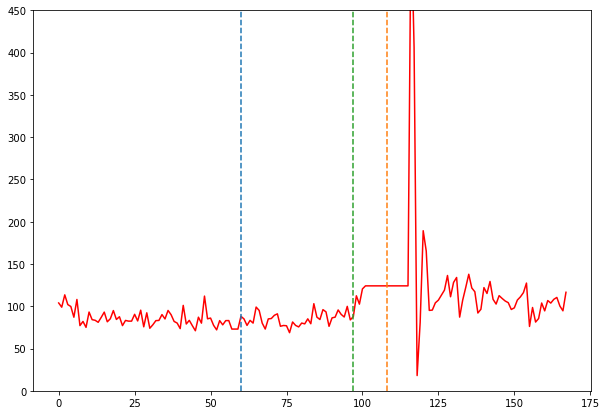

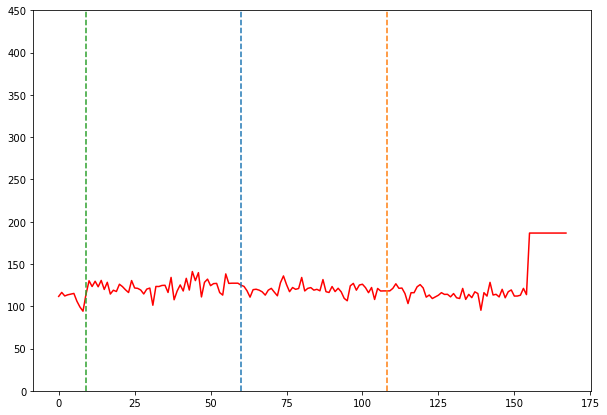

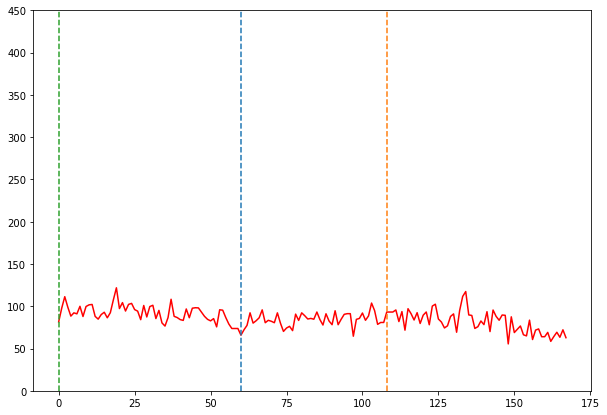

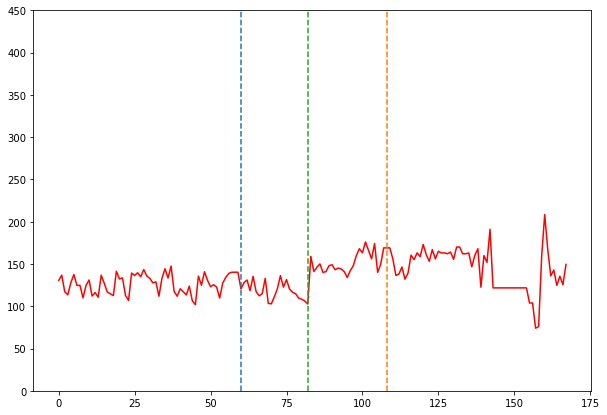

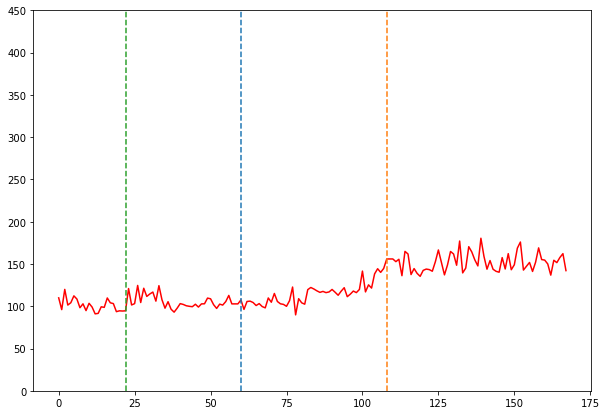

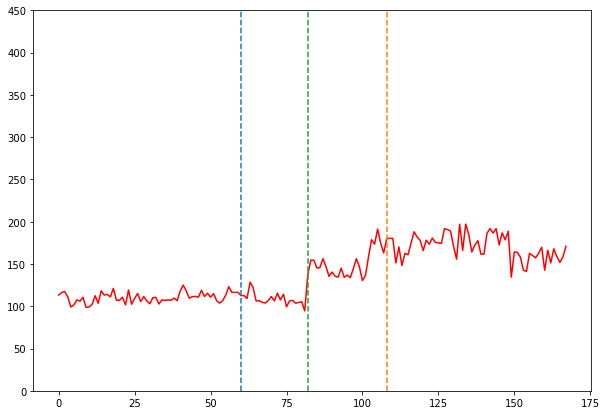

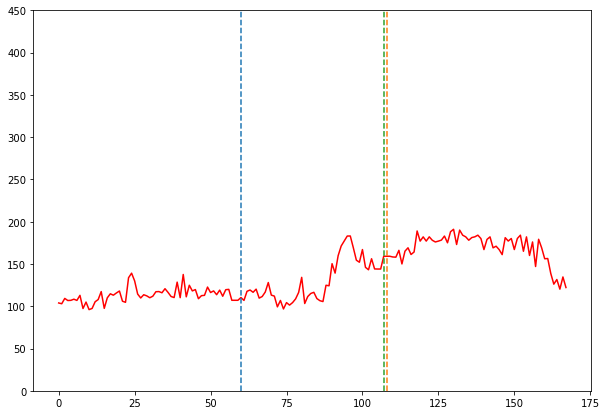

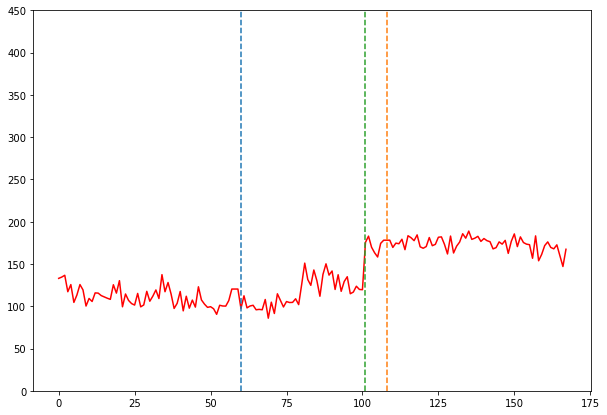

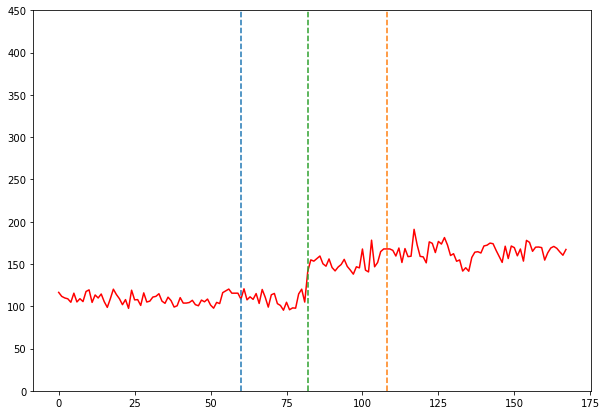

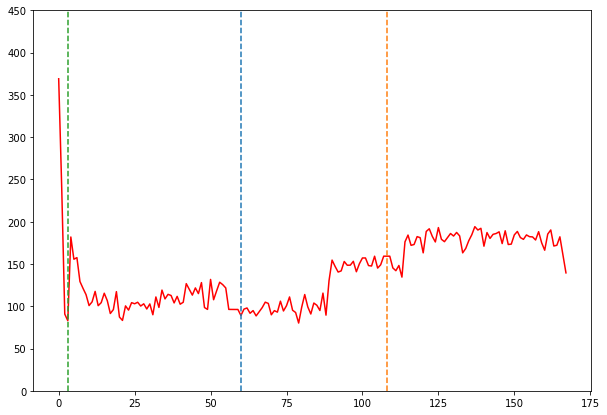

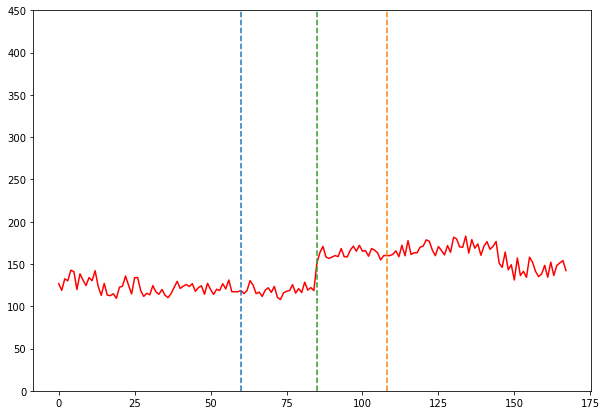

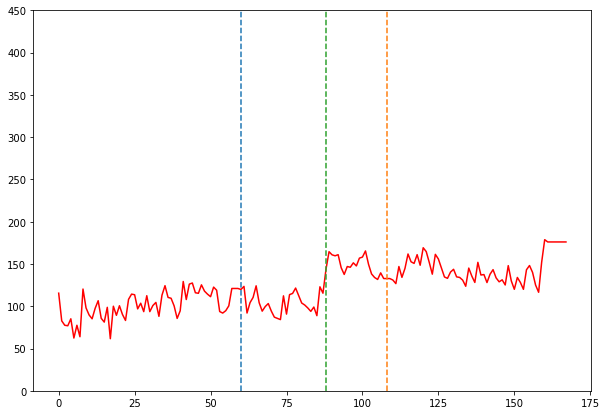

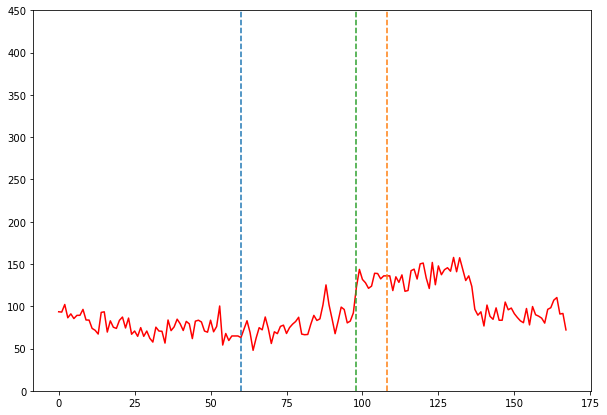

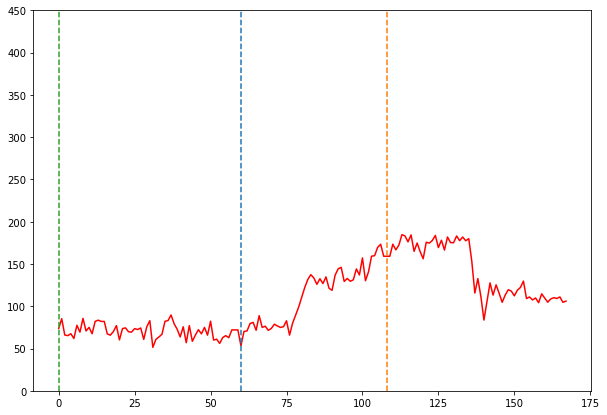

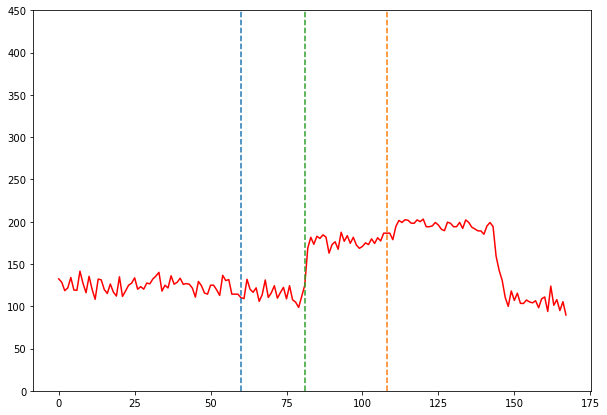

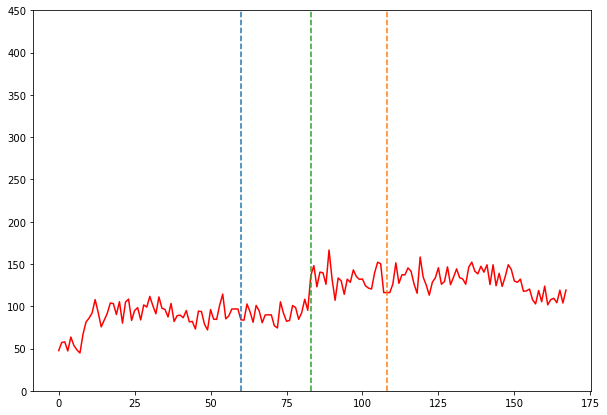

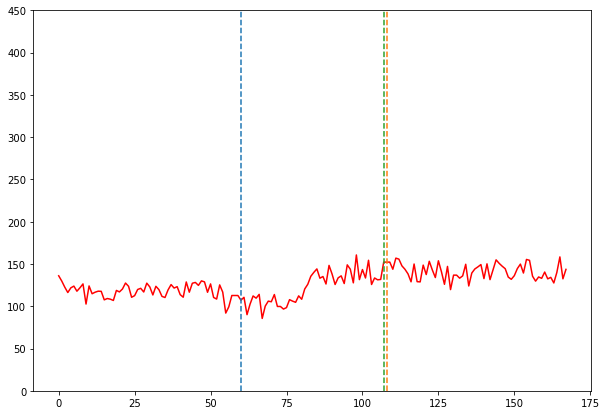

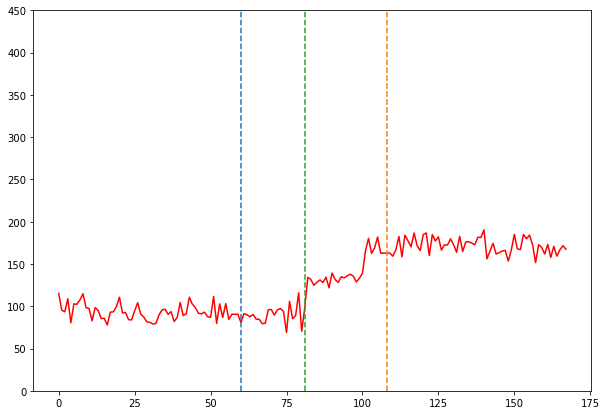

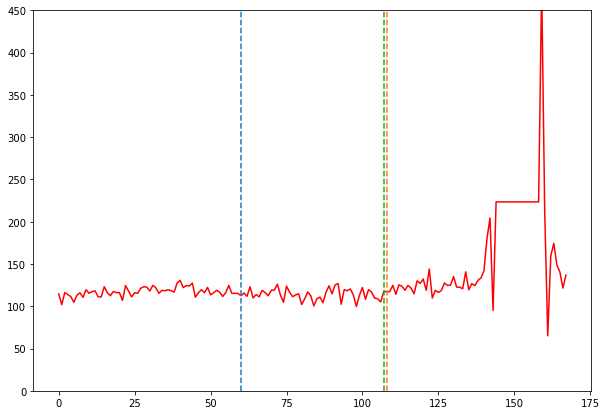

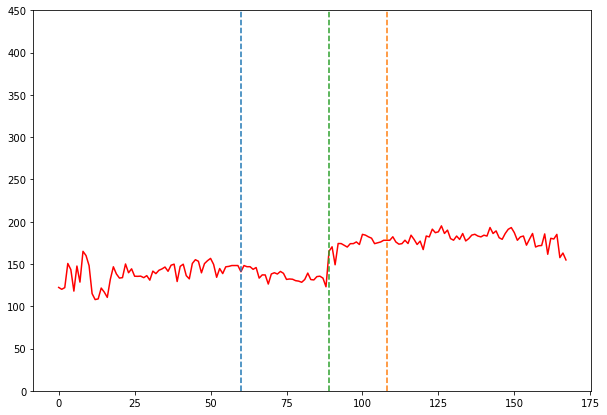

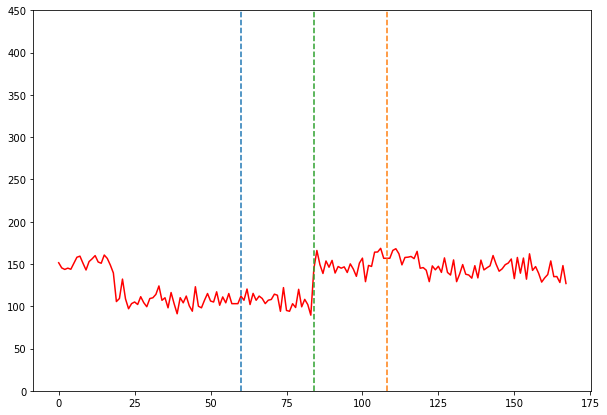

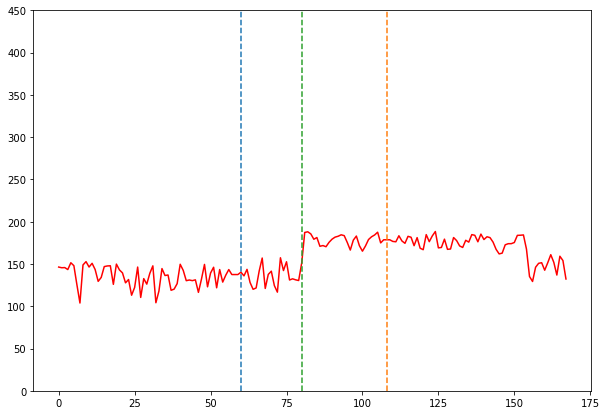

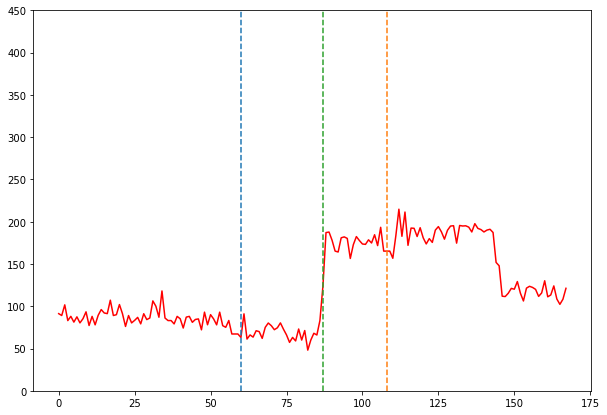

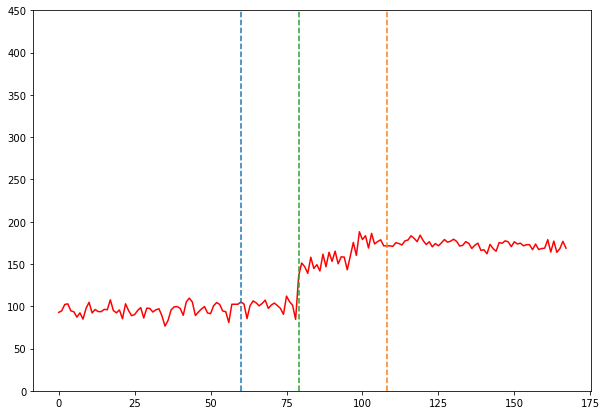

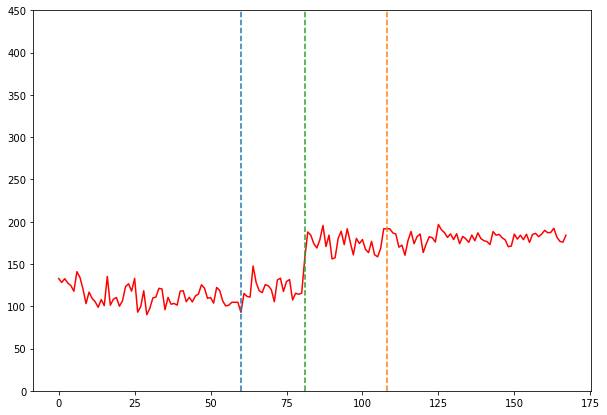

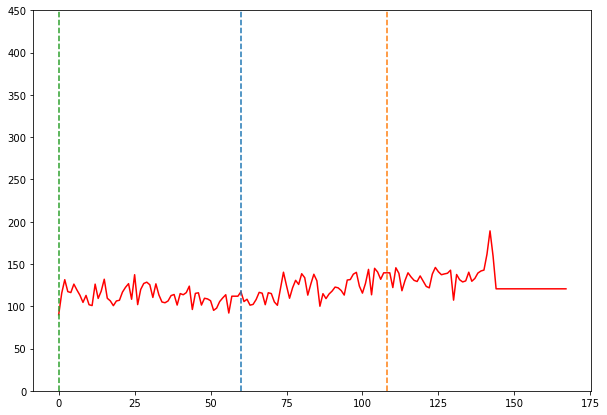

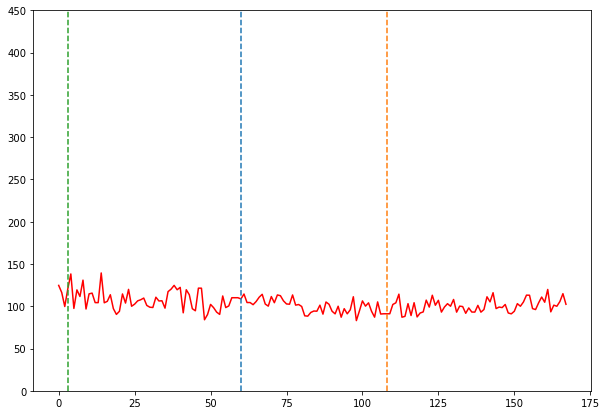

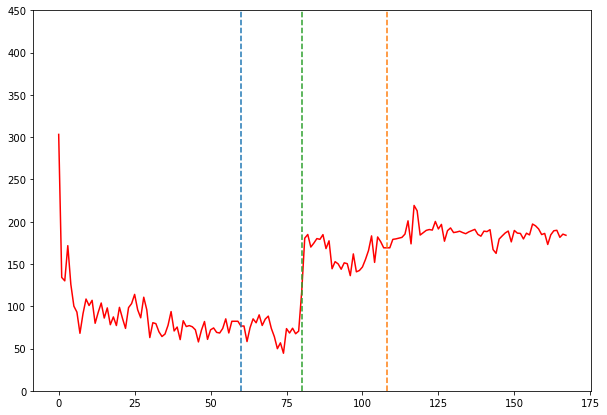

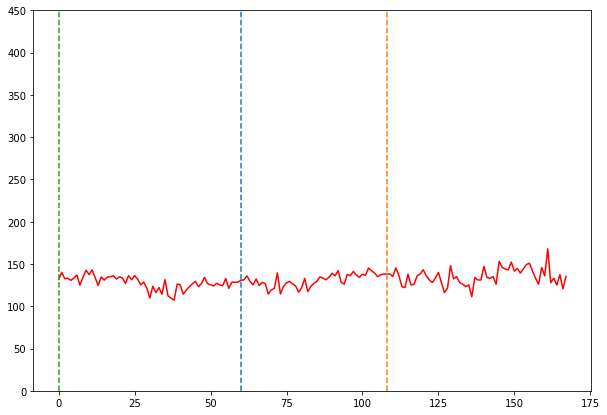

In [18]:
grad_max = np.array([np.argmax(np.gradient(data[32, target_idx, 0:108][i], edge_order=2)) for i in range(40)])
for i in range(40):
    plt.figure(figsize=(10,7))
    plt.plot(data[32, target_idx, :][i], c='r')
    plt.plot([(0.5)*120, (0.5)*120], [0, 450], '--')
    plt.plot([(0.5+0.4)*120, (0.5+0.4)*120], [0, 450], '--')
    plt.plot([grad_max[i], grad_max[i]], [0, 450], '--')
    plt.ylim([0,450])

In [19]:
grad_max = np.array([np.argmax(np.gradient(data[32, :, 0:108][i], edge_order=2)) for i in range(np.shape(data)[1])])

In [20]:
np.median(grad_max[np.argwhere(non_target_idx).ravel()]) / 120 - 0.5

0.050000000000000044

In [21]:
np.median(grad_max[np.argwhere(target_idx).ravel()]) / 120 - 0.5

0.17500000000000004

In [152]:
target_idx_clean[target_idx].shape

(40,)

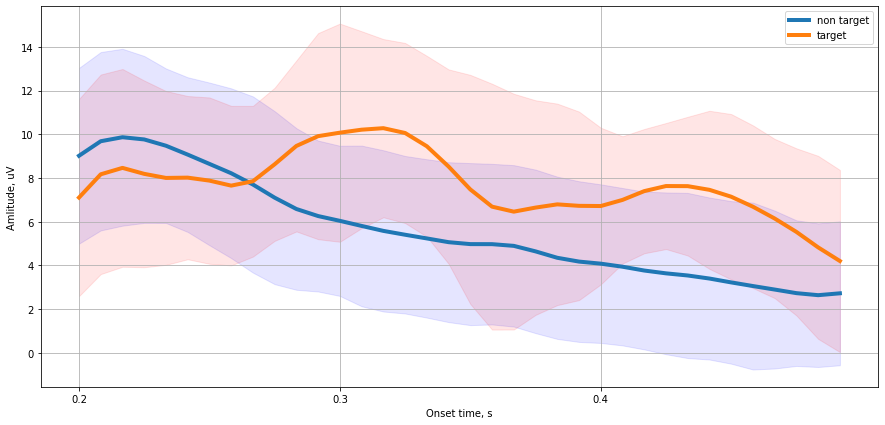

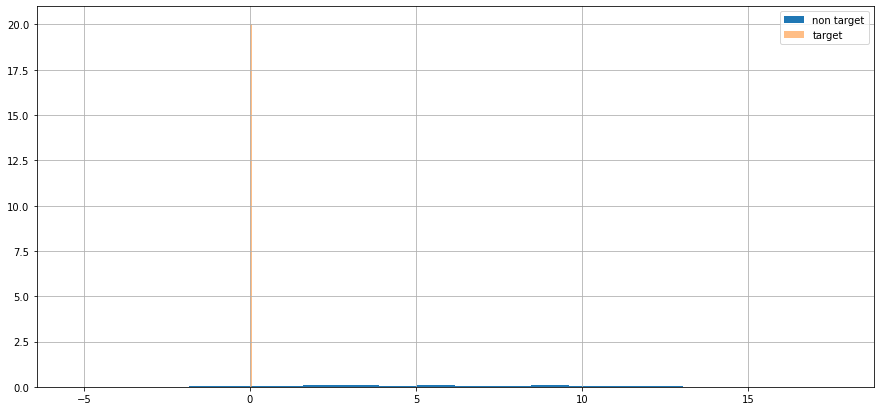

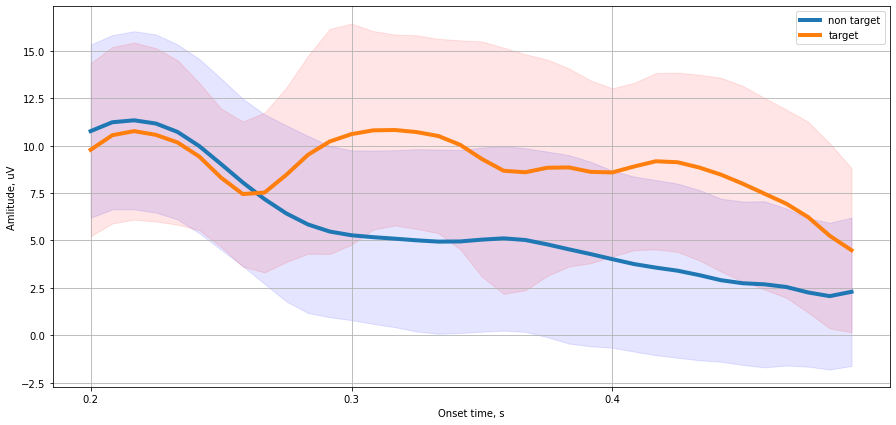

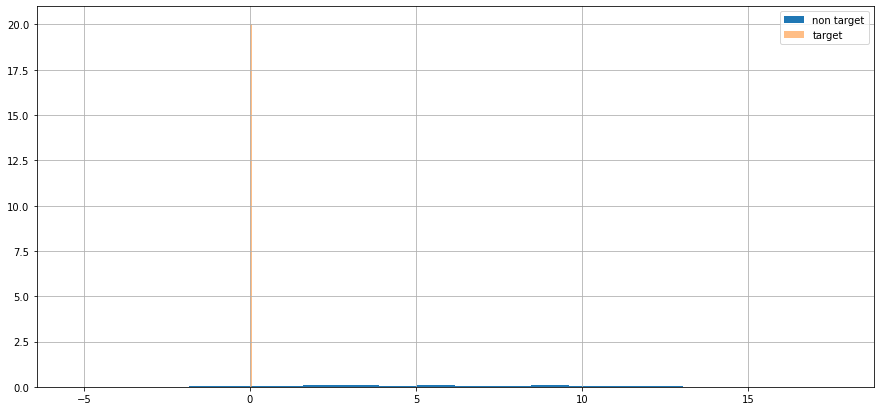

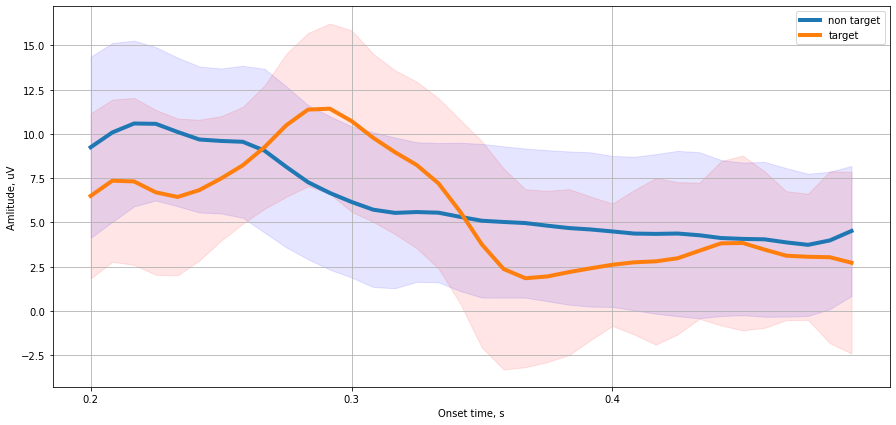

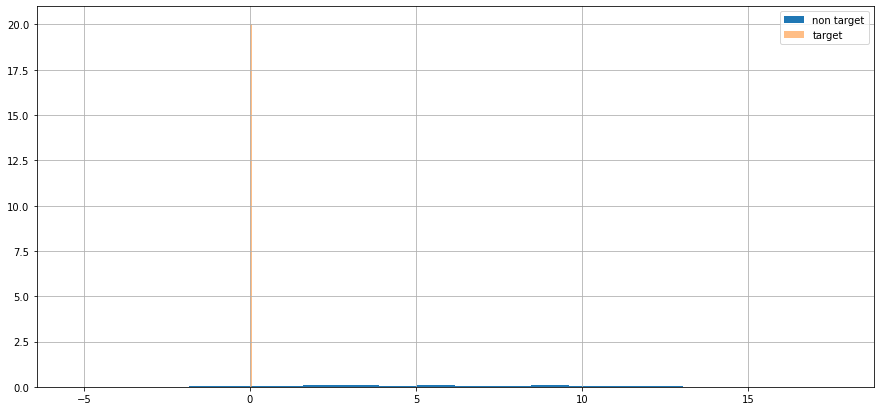

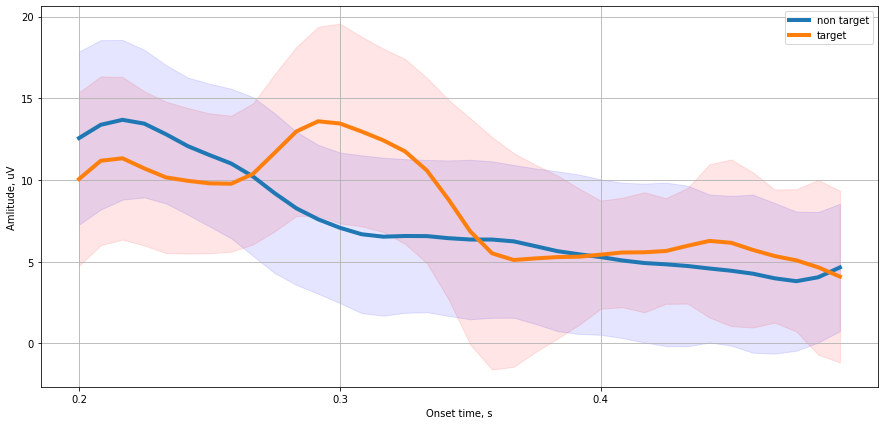

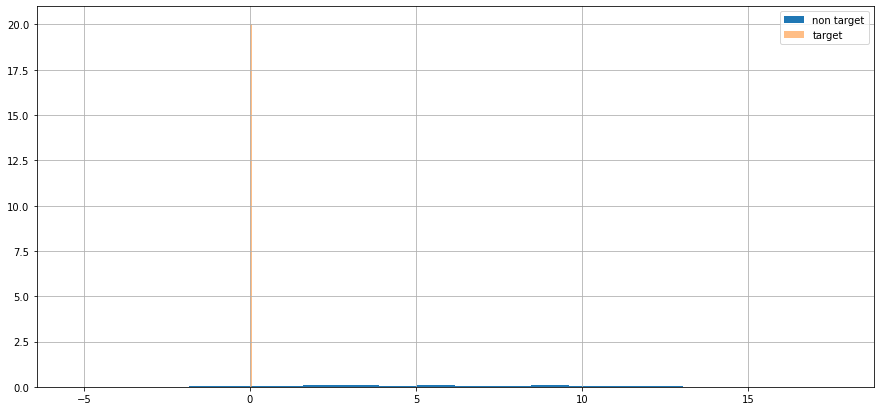

In [158]:
# grad_min = np.array([np.argmin(np.gradient(data[32, :, :][i], edge_order=2)) for i in range(np.shape(data)[1])])
grad_max = np.array([np.argmax(np.gradient(data[32, :, 60:108][i], edge_order=2)) for i in range(np.shape(data)[1])])
# grad_max = np.array([0 for i in range(np.shape(data)[1])])
grad_max+=60

non_target_idx = data[35, :, 1] == 1
target_idx = data[35, :, 1] == 2

target_idx_clean = np.array(target_idx)
target_idx_clean[target_idx] = target_idx_clean[target_idx] * (grad_max[target_idx] > 80) * (grad_max[target_idx] < 108)
start, end = int((0.2 + 0.5) * 120), int((0.5 + 0.5) * 120)
# start, end = int((-0.5 + 0.5) * 120), int((0.9 + 0.5) * 120)
ts_idx = slice(start, end)

chs = [23,24,27, 28]
# chs = np.arange(0, 32)

for ch_idx in chs:
    
    plt.figure(figsize=(15,7))
    
    # plot mean and confidence interval for non-target data
    nt_data = data[ch_idx, non_target_idx, ts_idx]
#     nt_data = np.mean(data[chs, non_target_idx, :], axis=0)
#     nt_data = data[ch_idx, non_target_idx, :]
    plt.plot(np.mean(nt_data, axis=0), label='non target', linewidth=4)
    ci_non_target = np.std(nt_data, axis=0)
    plt.fill_between(np.arange(np.shape(nt_data)[1]), (np.mean(nt_data, axis=0) - ci_non_target), (np.mean(nt_data, axis=0)+ci_non_target), color='b', alpha=.1)

    # plot mean and confidence interval for target data
    t_data = data[ch_idx, target_idx_clean, ts_idx]
        
#     t_data = np.mean(data[chs, target_idx, :], axis=0)
#     t_data = data[ch_idx, target_idx, :]
    plt.plot(np.mean(t_data, axis=0), label='target', linewidth=4)
    ci_target = np.std(t_data, axis=0)
    plt.fill_between(np.arange(np.shape(nt_data)[1]), (np.mean(t_data, axis=0) - ci_target), (np.mean(t_data, axis=0)+ci_target), color='r', alpha=.1)
    
    # plot mean and confidence interval for cleaned target data
#     t_data_clean = data[ch_idx, target_idx_clean, ts_idx]
#     t_data_clean = data[ch_idx, target_idx_clean, :]
#     plt.plot(np.mean(t_data_clean, axis=0), label='target clean', linewidth=4)
#     ci_target_clean = np.std(t_data_clean)
#     plt.fill_between(np.arange(np.shape(nt_data)[1]), (np.mean(t_data_clean, axis=0) - ci_target_clean), (np.mean(t_data_clean, axis=0)+ci_target_clean), color='r', alpha=.1)
    
#     # find EEG values 150ms after the target was found by eyes
#     n_trials = np.shape(t_data)[0]
#     n_tp = np.shape(t_data)[1]
#     EEG_peak_target = np.zeros((n_trials, 1))
#     for i, trial_idx in enumerate(np.argwhere(target_idx).ravel()):
#         ET_idx = grad_max
#         delay_ts = int(50/1000*120)
#         window_ts = 5
#         EEG_peak_target[i] = np.mean(data[ch_idx, trial_idx, ET_idx+delay_ts-window_ts:ET_idx+delay_ts+window_ts])
        
#     n_trials = np.shape(nt_data)[0]
#     n_tp = np.shape(nt_data)[1]
#     EEG_peak_non_target = np.zeros((n_trials, 1))
#     for i, trial_idx in enumerate(np.argwhere(non_target_idx).ravel()):
#         ET_idx = grad_max
#         delay_ts = int(50/1000*120)
#         window_ts = 5
#         EEG_peak_non_target[i] = np.mean(data[ch_idx, trial_idx, ET_idx+delay_ts-window_ts:ET_idx+delay_ts+window_ts])
    
#     n_trials = np.shape(t_data)[0]
#     n_tp = np.shape(t_data)[1]
#     EEG_peak_target_min = np.zeros((n_trials, 1))
#     for i, trial_idx in enumerate(np.argwhere(target_idx).ravel()):
#         ET_idx = grad_min[trial_idx]
#         delay_ts = int(150/1000*120)
#         window_ts = 3
#         EEG_peak_target_min[i] = np.mean(data[ch_idx, trial_idx, ET_idx+delay_ts-window_ts:ET_idx+delay_ts+window_ts])
             
    
    plt.xticks(np.arange(0, np.shape(nt_data)[1], 12), np.round(1/120 * np.arange(start, end, 12) - 0.5, 2))
    plt.legend()
    plt.xlabel('Onset time, s')
    plt.ylabel('Amlitude, uV')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(15,7))
    plt.hist(EEG_peak_non_target, density=True, bins=20, label = 'non target')
    plt.hist(EEG_peak_target, density=True, bins=20, alpha=0.5, label = 'target')
#     plt.hist(EEG_peak_target_min, density=True, bins=20, alpha=0.5, label = 'target min')
    plt.legend()
    plt.grid()
    plt.show()


In [23]:
grad_max.mean() 

85.06

In [24]:
data[24, non_target_idx, :].shape

(160, 168)

In [25]:
# chs = [23,24,27, 28]
chs = np.arange(23, 32)

In [26]:
X = data[chs[0], :, 0:108]
for ch_idx in range(len(chs)):
    X = np.append(X, data[chs[ch_idx], :, 0:108], axis=1)

In [27]:
y = data[35, :, 0]

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [31]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [32]:
y_pred = clf.predict(X_test)

In [33]:
y_pred

array([1., 1., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 2.])

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
accuracy_score(y_test, y_pred)

0.8636363636363636

In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
clf = LinearDiscriminantAnalysis()

In [38]:
scores = cross_val_score(clf, X, y, cv=5)

In [39]:
scores

array([0.95 , 0.825, 0.825, 0.875, 0.825])

In [40]:
print('CV: {:.2f} +- {:.2f}'.format(np.mean(scores), np.std(scores)))

CV: 0.86 +- 0.05
